<a href="https://colab.research.google.com/github/d-vf/Var_Volt_Control/blob/main/implementation/Var_Volt_Control_260725.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# Libraries

In [3]:
! apt-get install -y graphviz libgraphviz-dev #data viz
! pip install pygraphviz diagrams # diagrams
! pip install pandapower==3.1.2
! pip install scipy #transform .m to .pp, kron product,linv
! pip install pydot graphviz # for HG
! pip install plotly==6.1.1 #cute plots
! pip install -U Kaleido==1.0.0 #to save pdf IO
! pip install numpy scikit-learn scikit-optimize optuna hyperopt # parameter tuning

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 35 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,038 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgail18 

In [4]:
#Chrome driver is needed for kaleido
# Fetch a headless Chrome build just for this runtime
import kaleido
kaleido.get_chrome_sync()
# Restart the runtime (Runtime > Restart) so Kaleido sees Chrome

PosixPath('/usr/local/lib/python3.11/dist-packages/choreographer/cli/browser_exe/chrome-linux64/chrome')

# Data

In [5]:
import os
os.chdir("/content/drive/MyDrive/Diana Vieira Fernandes - Work folder/Var_Volt_Control")

In [6]:
os.chdir("/content/drive/MyDrive/Diana Vieira Fernandes - Work folder/Var_Volt_Control")
if not os.path.exists("images"):
    os.mkdir("images")

# Checklist

## Data & parameters
- network: Simulation has symmetric DER replacement.
- all values in p.u.
- matrices, same bus ordering.

## Modelling

- check inverse and correct sensitivity calculation from pandas and from scratch
- AC OPF versus Linear Model (LM)

- Slack bus impact
- analytical prox operator for state control
- don't project state update, do it trough dual updates
- reference bus consistently in both primal updates and in Jacobian inversion,
- always pin its Δθ to zero in iterative updates

- update rule for the entire network's state using the Kronecker product, which combines the network topology (the Laplacian, Lg) with the physical dynamics of the system (the Jacobian, J).

## pandapower version

- https://pandapower.readthedocs.io/en/latest/elements/gen.html now has storage, plus  PQ curves and min max S (but is not fully implemented v. 3.1.2)

## inner/outer loops

* outer Loop (control update)

Each iteration, agents update their main control variables (e.g., P,Q,z),dual variables, physical states, etc.

* inner (consensus+innovation)

For each outer iteration, agents run several (or until convergence) rounds of consensus+innovation (using Laplacian mixing + innovation injection) to agree on the global variable(s), the effective global control vector.

## Parameter Tunning
- Grid search (from sklearn.model_selection import ParameterGrid)  + bayesian (https://optuna.org/, https://hyperopt.github.io/hyperopt/, https://scikit-optimize.github.io/stable/auto_examples/hyperparameter-optimization.html)

In [7]:
import numpy as np
import pandas as pd
import pandapower as pp

S_max = 10.0
P_lim = Q_lim = S_max

net = pp.create_empty_network()
slack = pp.create_bus(net, vn_kv=20)
pp.create_ext_grid(net, slack, vm_pu=1.03)

# rectangular + circular envelope
rect = pd.DataFrame(
    dict(id_q_capability_curve=0,
         p_mw=[-P_lim, -P_lim, P_lim, P_lim],
         q_min_mvar=[-Q_lim]*4,
         q_max_mvar=[ Q_lim]*4)
)
angles = np.linspace(0, 2*np.pi, 36, endpoint=False)
circle = pd.DataFrame(
    dict(p_mw=S_max*np.cos(angles),
         q_min_mvar=-S_max*np.sin(angles),
         q_max_mvar= S_max*np.sin(angles))
)

# four-quadrant inverter with P/Q limits
bus_inv = pp.create_bus(net, vn_kv=20)
pp.create_gen(
    net,
    bus=bus_inv,
    p_mw=0,
    vm_pu=1.0,
    controllable=True,
    min_p_mw=-P_lim,  max_p_mw=P_lim,   # active-power limits
    min_q_mvar=-Q_lim, max_q_mvar=Q_lim, # reactive-power limits
    sn_mva=S_max,
    name="4-quadrant inverter"
)

# local load
pp.create_load(net, bus_inv, p_mw=2, q_mvar=0.5)

# optimal power flow with limits enforced
pp.runopp(net)

print(net.res_gen[["p_mw", "q_mvar", "vm_pu"]])
#reactive_capability_curve (bool, False) - True if both the id_q_capability_curve_characteristic and the curve style are present in the generator
#id_q_capability_curve_characteristic (int, None) - references the index of the characteristic from the net.q_capability_curve_characteristic table (id_q_capability_curve column)
#curve_style (string, None) - The curve style of the generator represents the relationship between active power (P) and reactive power (Q). It indicates whether the reactive power remains constant as the active power changes or varies dynamically in response to it, e.g. “straightLineYValues” and “constantYValue”

   p_mw  q_mvar  vm_pu
0   0.0     0.0    0.0


# Simulation

*  using the same network of prior work


In [8]:
import pandas as pd
cluster_medians_solar = pd.read_csv('https://raw.githubusercontent.com/d-vf/P2PEnergyTrading/main/Data/cluster_medians_solar.csv', header=0, sep=',')
cluster_medians = pd.read_csv('https://raw.githubusercontent.com/d-vf/P2PEnergyTrading/main/Data/cluster_medians.csv', header=0, sep=',')
cluster_medians_com = pd.read_csv('https://raw.githubusercontent.com/d-vf/P2PEnergyTrading/main/Data/cluster_medians_com.csv', header=0, sep=',')

Bus voltage results:
       vm_pu  va_degree
0   1.000000   0.000000
1   1.000000   0.000000
2   0.983302 -30.386276
3   0.975552 -30.156447
4   0.967817 -29.922940
5   0.960099 -29.685675
6   0.955688 -29.502395
7   0.951286 -29.317416
8   0.946894 -29.130719
9   0.942512 -28.942284
10  0.938141 -28.752092
11  0.938141 -28.752092
12  0.967817 -29.922940
13  0.947791 -29.114552
14  0.935579 -28.528460
15  0.923468 -27.926930
16  0.913170 -27.398683
17  0.951286 -29.317416
18  0.926906 -27.669929
19  0.938141 -28.752092
20  1.000000   0.000000
21  0.980567 -30.670595
22  0.955384 -29.881137
23  1.000000   0.000000
24  0.967055 -31.267080
25  0.937078 -30.880952
26  0.907147 -30.469323
27  0.887022 -30.175064
28  0.866922 -29.867151
29  0.856829 -29.705144
30  0.846744 -29.539278
31  0.836666 -29.369413
32  0.836666 -29.369413
33  0.886274 -29.719544
34  0.865560 -28.933739
35  0.865560 -28.933739
36  0.836223 -27.526938
37  0.886274 -29.719544
38  0.845664 -29.045157
39  0.845664 -29.04

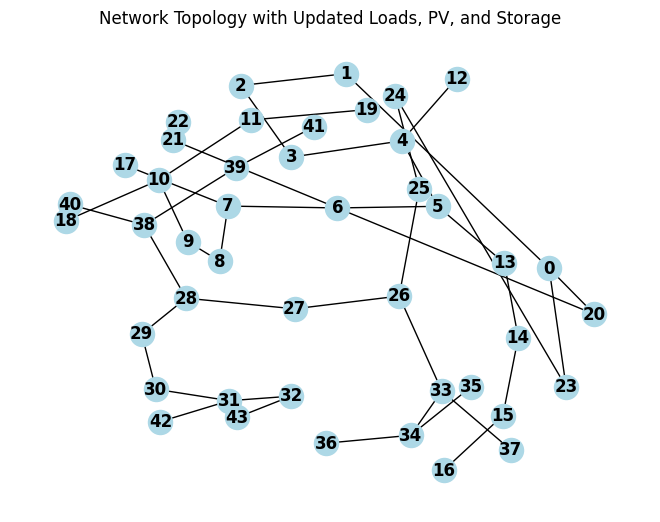

In [9]:
import pandapower as pp
import pandapower.networks as pn
import pandapower.plotting as plot
from pandapower.plotting.plotly import vlevel_plotly
import plotly.io as pio
import networkx as nx
import numpy as np
import pandas as pd
import math
from pandapower.control import ConstControl
from pandapower.pypower.makeYbus import makeYbus
import matplotlib.pyplot as plt


# Create and visualize the network
net = pn.create_cigre_network_lv()
net.name = "cigre network lv"
fig = vlevel_plotly(net)
pio.show(fig)
n_buses = len(net.bus)

# Prepare the network for simulation: Remove existing loads, sgens, and gens
net.load.drop(net.load.index, inplace=True)
net.sgen.drop(net.sgen.index, inplace=True)
net.gen.drop(net.gen.index, inplace=True)

# Process load data from cluster medians (select hour 11)
transposed_df = cluster_medians.T
first_row = transposed_df.iloc[:, 11]

# Identify extreme buses based on the network graph
graph = pp.topology.create_nxgraph(net)
extreme_buses = [node for node, degree in graph.degree() if degree == 1]

# For simplicity, split the extreme buses into two groups
selected_buses_odd = extreme_buses[1::2]    # for loads
selected_buses_even = extreme_buses[0::2]   # for solar/PV & storage

# Define a scaling factor to simulate large deviations
large_load_factor = 5.0  # Increase load by 5 times
## voltage drop

# Add loads to selected odd buses using load data
for bus in selected_buses_odd:
    # Use the first value of the load profile (in Watts)
    load = first_row.iloc[0] * large_load_factor
    q_value = np.abs(load * np.tan(np.arccos(0.7)))  # assume PF = 0.7
    sn_mva = np.sqrt((load/1e3)**2 + (q_value/1e3)**2)
    pp.create_load(net, bus=bus, p_mw=load/1e3, q_mvar=q_value/1e3,
                   scaling=1.0, sn_mva=sn_mva, in_service=True, controllable=True)

# Process solar data from cluster medians for solar generation (select hour 11)
transposed_df_solar = cluster_medians_solar.T
first_row_solar = transposed_df_solar.iloc[:, 11]

# Add PV (solar generation) to selected even buses – mark all as controllable
for bus in selected_buses_even:
    solar_value = first_row_solar.iloc[0] * large_load_factor  # use first solar value (Watts)
    q_solar = np.abs(solar_value * np.tan(np.arccos(0.7)))
    sn_mva = np.sqrt((solar_value/1e3)**2 + (q_solar/1e3)**2)
    pp.create_sgen(net, bus=bus, p_mw=solar_value/1e3, q_mvar=q_solar/1e3,
                   sn_mva=sn_mva, scaling=1.0, type='wye', in_service=False, controllable=True)

#in_service=False will prevent those elements from being included in the power flow calculation.

# Create a reactive power controller for controllable sgens
ConstControl(net, element='sgen', variable='q_mvar',
             element_index=net.sgen[net.sgen.controllable].index,
             profile_name='reactive_power_profile')

# Increase reactive power demand at bus 18
if not net.load[net.load.bus == 18].empty:
    idx = net.load[net.load.bus == 18].index[0]
    # Increase reactive demand (e.g., double it)
    net.load.at[idx, 'q_mvar'] = net.load.at[idx, 'q_mvar'] * 2.0
else:
    print("No load found at bus 18.")

# Add additional controllable sgens for voltage control and storage
# (All PV and storage assets are controllable.)

#for bus in selected_buses_even:
    # Additional PV asset for voltage control
#    pp.create_sgen(net, bus=bus, p_mw=0.005, q_mvar=0.0, scaling=1.0,
#                   controllable=True, in_service=True, max_q_mvar=0.005, min_q_mvar=-0.005)
    # Storage asset (modeled as sgen) for voltage support
    #pp.create_sgen(net, bus=12, p_mw=0.2, q_mvar=0.2, scaling=1.0,
#controllable=True, in_service=True, max_q_mvar=0.4, min_q_mvar=-0.04)

# additional controllable loads if desired
#for bus in selected_buses_even:
#    pp.create_load(net, bus=bus, p_mw=0.003, q_mvar=0.001, scaling=1.0,
#                   controllable=True, in_service=True)


# Create external grid connection if not already present (assume at bus 0)
if net.ext_grid.empty:
    pp.create_ext_grid(net, bus=0, vm_pu=1.0, name="Grid Connection")

# Run power flow and check voltage results
pp.runpp(net)

print("Bus voltage results:")
print(net.res_bus[['vm_pu', 'va_degree']])

# Store baseline voltage deviations
baseline_voltages = net.res_bus['vm_pu'].copy()

#  Visualize the network with updated elements
graph = pp.topology.create_nxgraph(net)
nx.draw(graph, with_labels=True, node_color="lightblue", font_weight="bold")
plt.title("Network Topology with Updated Loads, PV, and Storage")
plt.show()

# Construct the Adjacency Matrix from network elements
adj_matrix = np.zeros((n_buses, n_buses))
delta_rad = math.radians(30)  # default angle for capacity calculation

# Lines: Use reactance and bus voltages to approximate capacity
for i, line in net.line.iterrows():
    from_bus = int(line.from_bus)
    to_bus = int(line.to_bus)
    reactance = line.x_ohm_per_km  # if length available, multiply by line length

    v_from = net.res_bus.vm_pu.loc[from_bus] * net.bus.vn_kv.loc[from_bus]
    v_to = net.res_bus.vm_pu.loc[to_bus] * net.bus.vn_kv.loc[to_bus]
    p_capacity = (v_from * v_to / reactance) * np.sin(delta_rad)
    adj_matrix[from_bus, to_bus] = p_capacity
    adj_matrix[to_bus, from_bus] = p_capacity

# Transformers: Use rated capacity (sn_mva)
for i, trafo in net.trafo.iterrows():
    hv_bus = int(trafo.hv_bus)
    lv_bus = int(trafo.lv_bus)
    sn_mva = trafo.sn_mva
    adj_matrix[hv_bus, lv_bus] = sn_mva
    adj_matrix[lv_bus, hv_bus] = sn_mva

# External grid connections: Connect external grid bus to others (approximation)
for i, eg in net.ext_grid.iterrows():
    bus = int(eg.bus)
    p_mw = eg.vm_pu * net.bus.vn_kv.loc[bus]
    if bus != 0:
        adj_matrix[0, bus] = p_mw
        adj_matrix[bus, 0] = p_mw

# Switches: If open, set connection capacity to zero

net.switch.loc[net.switch.et == "b", "closed"] = True

for i, switch in net.switch.iterrows():
    bus = int(switch.bus)
    element = int(switch.element)
    if switch.closed:
        if switch.et in ['l', 't']:  # Line or transformer switch
            P_capacity_switch = adj_matrix[bus, element]
        elif switch.et == 'b':  # Bus switch; use custom logic (here zero)
            P_capacity_switch = 0
    else:
        P_capacity_switch = 0
    adj_matrix[bus, element] = P_capacity_switch
    adj_matrix[element, bus] = P_capacity_switch

#net.switch
#https://pandapower.readthedocs.io/en/v2.2.1/elements/switch.html
#Two buses that are connected through a closed bus-bus switches are fused in the power flow if the switch is closed or separated if the switch is open.
# Additional connection: Link external grid with transformer HV buses

ext_grid_bus = net.ext_grid.bus.values[0]
s_sc_max_mva = net.ext_grid.s_sc_max_mva.values[0] if 's_sc_max_mva' in net.ext_grid.columns else 0
for i, hv_bus in enumerate(net.trafo.hv_bus.values):
    trafo_capacity = net.trafo.sn_mva.values[i]
    connection_capacity = min(s_sc_max_mva, trafo_capacity) if s_sc_max_mva else trafo_capacity
    adj_matrix[ext_grid_bus, hv_bus] = connection_capacity
    adj_matrix[hv_bus, ext_grid_bus] = connection_capacity

adj_matrix_df = pd.DataFrame(adj_matrix)
#print("Adjacency Matrix:")
#print(adj_matrix_df)

In [10]:
Ybus, Yf, Yt = makeYbus(net._ppc['baseMVA'], net._ppc['bus'], net._ppc['branch'])
Ybus_dense = Ybus.todense()
print("Ybus shape:", Ybus_dense.shape)

Ybus shape: (44, 44)


In [11]:
import numpy as np

#pp.runpp(net)

#J = net._ppc["internal"]["J"].todense()
#J.shape # just uses internal buses not 44 * 44
#https://github.com/e2nIEE/pandapower/blob/develop/tutorials/internal_datastructure.ipynb

# 1) reduced Jacobian
J_red   = net._ppc["internal"]["J"].toarray()   # shape=(2·n_pvpq,2·n_pvpq)
pv       = net._ppc["internal"]["pv"]
pq       = net._ppc["internal"]["pq"]
ppc_buses = np.hstack((pv, pq))

# 2) flatten the bus_lookup
bus_lookup = np.array(net._ppc["internal"]["bus"]).flatten().astype(int)

# 3) make reverse map ppc→index in J_red
ppc2red = {ppc_buses[i]: i for i in range(len(ppc_buses))}

# 4) expand out to full
nb      = len(net.bus)
J_full  = np.zeros((2*nb, 2*nb))
nred    = len(ppc_buses)
for i in range(nb):
    p_i = int(bus_lookup[i])
    if p_i in ppc2red:
        ri = ppc2red[p_i]
        for j in range(nb):
            p_j = int(bus_lookup[j])
            if p_j in ppc2red:
                cj = ppc2red[p_j]
                J_full[i,      j]      = J_red[ri,        cj]                # ∂P_i/∂θ_j
                J_full[i,      nb + j] = J_red[ri,        nred + cj]          # ∂P_i/∂V_j
                J_full[nb + i, j]      = J_red[nred + ri, cj]                # ∂Q_i/∂θ_j
                J_full[nb + i, nb + j] = J_red[nred + ri, nred + cj]          # ∂Q_i/∂V_j

# Extract Controllable Buses from sgen Table
# Only sgens (static generators) are controllable
controllable_buses = net.sgen.bus.values.astype(int)
# 5) build sensitivities
J_inv    = np.linalg.pinv(J_full)
ctrl_arr = np.array(controllable_buses, dtype=int)

K_theta = np.hstack((J_inv[:nb,        ctrl_arr],
                     J_inv[:nb, nb + ctrl_arr]))
K_V     = np.hstack((J_inv[nb:,        ctrl_arr],
                     J_inv[nb:, nb + ctrl_arr]))

In [12]:
import numpy as np
import pandapower as pp
import pandapower.networks as pn
from pandapower.pypower.makeYbus import makeYbus

# Full Jacobian (Sensitivity)

Ybus, Yf, Yt = makeYbus(net._ppc['baseMVA'], net._ppc['bus'], net._ppc['branch'])
Ybus_dense = Ybus.todense()
print("Ybus shape:", Ybus_dense.shape)

def create_full_jacobian(Ybus_full, net_res_bus, baseMVA):
    """
    Compute the full Jacobian submatrices (H, N, K, L) for all buses
    using the full Ybus matrix, bus voltage data, and power injections.

    Parameters
    ----------
    Ybus_full : np.ndarray
        The full bus admittance matrix in dense format (n_buses x n_buses).
    net_res_bus : pandas.DataFrame
        DataFrame containing bus voltage magnitudes 'vm_pu',
        voltage angles 'va_degree', active power 'p_mw', and
        reactive power 'q_mvar' from a power flow result.
    baseMVA : float
        The power base of the network (net.sn_mva).

    Returns
    -------
    H, N, K, L : np.ndarray
        The Jacobian submatrices:
          H: ∂P/∂θ sensitivities,
          N: ∂P/∂V sensitivities,
          K: ∂Q/∂θ sensitivities,
          L: ∂Q/∂V sensitivities.
    """
    num_buses = len(net_res_bus)
    # Extract voltage magnitudes and convert angles to radians.
    V = net_res_bus["vm_pu"].values
    theta = np.deg2rad(net_res_bus["va_degree"].values)

    baseMVA = 1

    # Get power injections in per unit
    # Net injection = Generation - Load + Slack Injection
    # net.res_bus.p_mw and q_mvar already represent the *net* injection at each bus
    # after the power flow solution (including slack).
    P_pu = net_res_bus["p_mw"].values / baseMVA
    Q_pu = net_res_bus["q_mvar"].values / baseMVA


    # Initialize submatrix arrays.
    H = np.zeros((num_buses, num_buses))
    N = np.zeros((num_buses, num_buses))
    K = np.zeros((num_buses, num_buses))
    L = np.zeros((num_buses, num_buses))

    # Extract conductance (G) and susceptance (B) matrices.
    G = np.array(Ybus_full.real)
    B = np.array(Ybus_full.imag)

    # --- Off-diagonal entries (i != j) ---
    for i in range(num_buses):
        for j in range(num_buses):
            if i != j:
                dtheta = theta[i] - theta[j]
                H[i, j] = V[i] * V[j] * (G[i, j] * np.sin(dtheta) - B[i, j] * np.cos(dtheta))
                N[i, j] = V[i] * (G[i, j] * np.cos(dtheta) + B[i, j] * np.sin(dtheta)) * V[j]
                K[i, j] = -V[i] * V[j] * (G[i, j] * np.cos(dtheta) + B[i, j] * np.sin(dtheta))
                L[i, j] = V[i] * (G[i, j] * np.sin(dtheta) - B[i, j] * np.cos(dtheta)) * V[j]

    # --- Diagonal entries ---
    for i in range(num_buses):
        H[i, i] = -np.sum([H[i, j] for j in range(num_buses) if j != i])
        K[i, i] = -np.sum([K[i, j] for j in range(num_buses) if j != i])

        # Corrected N_ii formula: dPi / d|Vi|
        # N_ii = Pi/|Vi| + |Vi|*G_ii
        if V[i] != 0: # Avoid division by zero if a bus voltage is exactly 0
             N[i, i] = P_pu[i] / V[i] + V[i] * G[i, i]
        else:
             N[i, i] = 0 # Or handle as an error/special case

        # Corrected L_ii formula: dQi / d|Vi|
        # L_ii = Qi/|Vi| - |Vi|*B_ii
        if V[i] != 0: # Avoid division by zero
             L[i, i] = Q_pu[i] / V[i] - V[i] * B[i, i]
        else:
             L[i, i] = 0 # Or handle as an error/special case

    # --- Off-diagonal entries (i != j) ---
    H = np.zeros((num_buses, num_buses))
    N = np.zeros((num_buses, num_buses))
    K = np.zeros((num_buses, num_buses))
    L = np.zeros((num_buses, num_buses))

    for i in range(num_buses):
        for j in range(num_buses):
            if i != j:
                dtheta = theta[i] - theta[j]
                # dPi/d(theta_j)
                H[i, j] = V[i] * V[j] * (G[i, j] * np.sin(dtheta) - B[i, j] * np.cos(dtheta))
                # dPi/d|V_j|
                N[i, j] = V[i] * (G[i, j] * np.cos(dtheta) + B[i, j] * np.sin(dtheta)) * V[j] / V[j] # Simplified: V[i] * (term)
                 # Correct N_ij:
                N[i, j] = V[i] * (G[i, j] * np.cos(dtheta) + B[i, j] * np.sin(dtheta))

                # dQi/d(theta_j)
                K[i, j] = -V[i] * V[j] * (G[i, j] * np.cos(dtheta) + B[i, j] * np.sin(dtheta))
                # dQi/d|V_j|
                L[i, j] = V[i] * (G[i, j] * np.sin(dtheta) - B[i, j] * np.cos(dtheta)) * V[j] / V[j] # Simplified: V[i] * (term)
                 # Correct L_ij:
                L[i, j] = V[i] * (G[i, j] * np.sin(dtheta) - B[i, j] * np.cos(dtheta))


    # --- Diagonal entries ---
    # Recalculate diagonals using the sum property after correcting off-diagonals
    for i in range(num_buses):
        H[i, i] = -np.sum([H[i, j] for j in range(num_buses) if j != i])
        K[i, i] = -np.sum([K[i, j] for j in range(num_buses) if j != i])

        # N_ii formula: dPi / d|Vi|
        if V[i] != 0: # Avoid division by zero
             N[i, i] = P_pu[i] / V[i] + V[i] * G[i, i]
        else:
             N[i, i] = 0 # Or handle as an error/special case

        # L_ii formula: dQi / d|Vi|
        if V[i] != 0: # Avoid division by zero
             L[i, i] = Q_pu[i] / V[i] - V[i] * B[i, i]
        else:
             L[i, i] = 0 # Or handle as an error/special case


    return H, N, K, L


# 4. Compute the Sensitivity (Jacobian) Matrices Using Ybus (Corrected Call)

H, N, K, L = create_full_jacobian(Ybus_dense, net.res_bus, net.sn_mva)

# Display the shapes of the resulting Jacobian submatrices.
print("Jacobian Submatrices shapes:")
print("H:", H.shape)
print("N:", N.shape)
print("K:", K.shape)
print("L:", L.shape)

Ybus shape: (44, 44)
Jacobian Submatrices shapes:
H: (44, 44)
N: (44, 44)
K: (44, 44)
L: (44, 44)


In [13]:
#Ybus = Ybus.toarray()

#G = Ybus_dense.real
#B = Ybus_dense.imag

# Extract conductance (G) and susceptance (B) matrices.
G = np.array(Ybus_dense.real)
B = np.array(Ybus_dense.imag)

# Simple approximations for sensitivity matrices:
H = -B   # Sensitivity of ΔP to Δθ
N = G    # Sensitivity of ΔP to ΔV
K = -G   # Sensitivity of ΔQ to Δθ
L = -B   # Sensitivity of ΔQ to ΔV

##https://github.com/e2nIEE/pandapower/blob/develop/pandapower/pf/create_jacobian.py

# Simulation setup

In [14]:
# ---------- Baseline Power Flow Results (Before Voltage Control) ----------

# Run power flow to get traditional measures (baseline, before voltage control is applied)
pp.runpp(net)

# Total resistive losses computed from line results (active power losses in MW)
total_losses = net.res_line.pl_mw.sum()

# Traditional voltage profile from power flow results (in kV)
trad_voltage = net.res_bus.vm_pu.values * net.bus.vn_kv.values

In [15]:
total_losses

np.float64(0.060383106490762145)

In [16]:
from pandapower.plotting.plotly import pf_res_plotly
#https://pandapower.readthedocs.io/en/latest/plotting/plotly/built-in_plots.html

pf_res_plotly(net)


Power Flow Results (Bus Voltages and Angles):


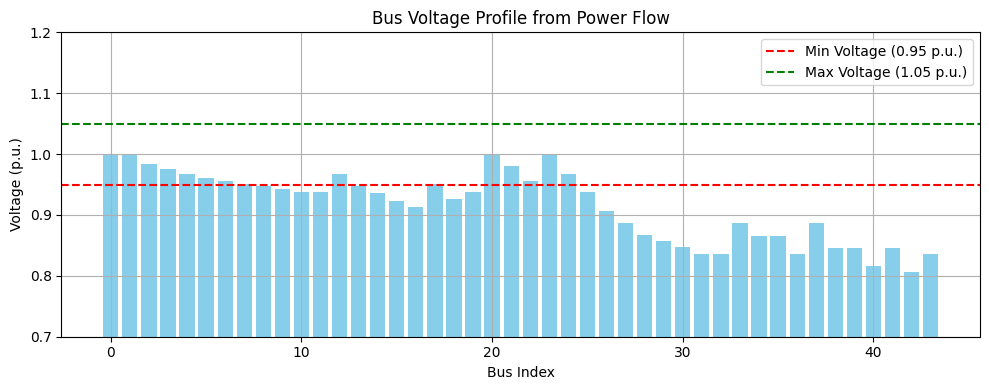

In [17]:
print("\nPower Flow Results (Bus Voltages and Angles):")
#print(net.res_bus[['vm_pu', 'va_degree']])

bus_indices = np.arange(len(net.res_bus))
voltages = net.res_bus['vm_pu'].values  # per unit voltages
angles = net.res_bus['va_degree'].values  # angles in degrees

# Save the initial bus results for later comparison
before_df = net.res_bus[['vm_pu', 'va_degree']].copy()

plt.figure(figsize=(10, 4))
plt.bar(bus_indices, voltages, color='skyblue')
plt.axhline(0.95, color='red', linestyle='--', label='Min Voltage (0.95 p.u.)')
plt.axhline(1.05, color='green', linestyle='--', label='Max Voltage (1.05 p.u.)')
plt.xlabel("Bus Index")
plt.ylabel("Voltage (p.u.)")
plt.title("Bus Voltage Profile from Power Flow")
plt.ylim(0.7, 1.2)  # Set y-axis limits between 0.7 and 1.2
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio
import kaleido



bus_indices = np.arange(len(net.res_bus))
voltages = net.res_bus['vm_pu'].values  # per unit voltages
angles = net.res_bus['va_degree'].values  # angles in degrees

before_df = net.res_bus[['vm_pu', 'va_degree']].copy()

# Create the Plotly figure
fig = go.Figure()

# Add bar chart for bus voltages
fig.add_trace(go.Bar(
    x=bus_indices,
    y=voltages,
    marker_color='skyblue',
    name='Voltage (p.u.)'
))

# Add horizontal lines for the voltage limits
fig.add_hline(y=0.95,
              line=dict(color='red', dash='dash'),
              annotation_text='Min Voltage (0.95 p.u.)',
              annotation_position="bottom right")
fig.add_hline(y=1.05,
              line=dict(color='green', dash='dash'),
              annotation_text='Max Voltage (1.05 p.u.)',
              annotation_position="top right")

# layout settings with Times New Roman font
fig.update_layout(
    title={
        "text": "Voltage drop - Baseline (Non-intervention)",
        "font": {"family": "Times New Roman", "size": 20}
    },
    xaxis_title={
        "text": "Bus Index",
        "font": {"family": "Times New Roman", "size": 14}
    },
    yaxis_title={
        "text": "Voltage (p.u.)",
        "font": {"family": "Times New Roman", "size": 14}
    },
    font=dict(
        family="Times New Roman",
        size=12,
        color="black"
    ),
    yaxis=dict(range=[0.7, 1.2]),
    template="plotly_white",
    legend=dict(
        font=dict(family="Times New Roman", size=12, color="black"),
        x=0.01, y=0.99
    )
)


fig.show()

# Save the figure as a PDF file using kaleido.
pio.write_image(fig, "bus_voltage_profile_before.pdf", format="pdf")

In [19]:
import pandapower as pp
import pandapower.networks as pn
import networkx as nx
import plotly.graph_objs as go
import plotly.io as pio
from networkx.drawing.nx_agraph import graphviz_layout
import kaleido

# Create graph from the adjacency matrix DataFrame
G = nx.Graph(adj_matrix_df)

# Extract the edges from the pandapower graph
edges_from_graph = list(G.edges())

# Extract the edges from lines, trafos, and switches
edges_from_lines = list(net.line[['from_bus', 'to_bus']].itertuples(index=False))
edges_from_trafos = list(net.trafo[['hv_bus', 'lv_bus']].itertuples(index=False))
edges_from_switches = [(switch.bus, switch.element) for switch in net.switch[net.switch.closed].itertuples(index=False)]

# Create a new directed graph (DiGraph) for a hierarchical layout
G = nx.DiGraph()
G.add_edges_from(edges_from_lines)
G.add_edges_from(edges_from_trafos)
G.add_edges_from(edges_from_switches)

# Remove selected buses from extreme_buses (calculated before to assign nodes, e.g. loads for all with degree less than 1 and 50% get sgen)
extreme_buses_1 = [bus_id for bus_id in extreme_buses if bus_id not in selected_buses_odd]

# Dictionary to specify colors for the nodes:
# - Bus 0: red
# - Buses in extreme_buses_1: green
# - Controlable assets (selected_buses_odd): orange
# - Other buses: grey
node_colors = {node: 'red' if node == 0
               else 'green' if node in extreme_buses_1
               else 'orange' if node in selected_buses_odd
               else 'grey'
               for node in net.bus.index}

# Define some edge colors (customize as needed)
edge_colors = {
    (0, 1): 'red',
    (0, 2): 'black',
}

# Get the layout of the graph using Graphviz's dot algorithm
pos = graphviz_layout(G, prog="dot")

# Manually adjust the positions of buses 0, 1, and 23 for vertical alignment
pos[0] = (333, 810)
pos[1] = (333, 810)
pos[23] = (333, 810)

fig = go.Figure()

# Loop through nodes and add them to the plot
for node in G.nodes:
    x, y = pos[node]
    color = node_colors.get(node, 'grey')
    fig.add_trace(go.Scatter(x=[x], y=[y], mode='markers',
                             marker=dict(size=10, color=color),
                             text=str(node), showlegend=False))

# Loop through edges and add them to the plot
for lv_bus, hv_bus in G.edges:
    x1, y1 = pos[lv_bus]
    x2, y2 = pos[hv_bus]
    color = edge_colors.get((lv_bus, hv_bus), 'black')
    fig.add_trace(go.Scatter(x=[x1, x2], y=[y1, y2], mode='lines',
                             line=dict(width=2, color=color), showlegend=False))

# Add a new trace for bus 18 with its name displayed and added to the legend
#if 18 in pos:
#    x, y = pos[18]
#    bus_name = "Increased Q"
#    fig.add_trace(go.Scatter(x=[x], y=[y], mode='markers+text',
#                             marker=dict(size=12, color='blue'),
                             #text=[bus_name],
#                             textposition="bottom right",
#                             name=bus_name))


# Annotate controllable assets with bus number labels
for bus in selected_buses_odd:
    if bus in pos:
        x, y = pos[bus]
        fig.add_annotation(
            x=x,
            y=y,
            text=f"Bus {bus}",
            showarrow=False,
            font=dict(color="black", size=14),
            xshift=14,
            yshift=14,
            xanchor="left",
            yanchor="top"
        )


# Annotate controllable assets with bus number labels
for bus in selected_buses_even:
    if bus in pos:
        x, y = pos[bus]
        fig.add_annotation(
            x=x,
            y=y,
            text=f"Bus {bus}",
            showarrow=False,
            font=dict(color="black", size=14),
            xshift=14,
            yshift=14,
            xanchor="left",
            yanchor="top"
        )
# Add legend entries with colors
legend_colors = {
    'Bus 0 (Slack)': 'red',
    'Ctrl assets': 'green',
    'Loads': 'orange',
    'iddle': 'grey'
}

for label, color in legend_colors.items():
    fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers',
                             marker=dict(size=14, color=color),
                             name=label, showlegend=True))

# Update layout settings
fig.update_layout(width=800, height=600, plot_bgcolor='white',
                  showlegend=True, legend=dict(orientation='h', x=0, y=1.1),
                  xaxis_visible=False, yaxis_visible=False,
                  font=dict(
                      family="'CMU Serif', serif",
                      size=18,
                      color="black"
                  ))
fig.update_yaxes(scaleanchor='x', scaleratio=0.5)

# Show the plot
fig.show()

fig.write_image("images/network_44_WB_var_volt.pdf", width=800, height=600, scale=2)

# Full Algo

In [28]:
import pandapower as pp
import pandapower.networks as pn
import pandapower.plotting as plot
from pandapower.plotting.plotly import vlevel_plotly
import plotly.io as pio
import networkx as nx
import numpy as np
import pandas as pd
import math
from pandapower.control import ConstControl
from pandapower.pypower.makeYbus import makeYbus
import matplotlib.pyplot as plt


# Create and visualize the network
net = pn.create_cigre_network_lv()
net.name = "cigre network lv"
fig = vlevel_plotly(net)
pio.show(fig)
n_buses = len(net.bus)

# Prepare the network for simulation: Remove existing loads, sgens, and gens
net.load.drop(net.load.index, inplace=True)
net.sgen.drop(net.sgen.index, inplace=True)
net.gen.drop(net.gen.index, inplace=True)

# Process load data from cluster medians (select hour 11)
transposed_df = cluster_medians.T
first_row = transposed_df.iloc[:, 11]

# Identify extreme buses based on the network graph
graph = pp.topology.create_nxgraph(net)
extreme_buses = [node for node, degree in graph.degree() if degree == 1]

# For simplicity, split the extreme buses into two groups
selected_buses_odd = extreme_buses[1::2]    # for loads
selected_buses_even = extreme_buses[0::2]   # for solar/PV & storage

# Define a scaling factor to simulate large deviations
large_load_factor = 5.0  # Increase load by 5 times
## voltage drop

# Add loads to selected odd buses using load data
for bus in selected_buses_odd:
    # Use the first value of the load profile (in Watts)
    load = first_row.iloc[0] * large_load_factor
    q_value = np.abs(load * np.tan(np.arccos(0.7)))  # assume PF = 0.7
    sn_mva = np.sqrt((load/1e3)**2 + (q_value/1e3)**2)
    pp.create_load(net, bus=bus, p_mw=load/1e3, q_mvar=q_value/1e3,
                   scaling=1.0, sn_mva=sn_mva, in_service=True, controllable=True)

# Process solar data from cluster medians for solar generation (select hour 11)
transposed_df_solar = cluster_medians_solar.T
first_row_solar = transposed_df_solar.iloc[:, 11]

# Add PV (solar generation) to selected even buses – mark all as controllable
for bus in selected_buses_even:
    solar_value = first_row_solar.iloc[0] * large_load_factor  # use first solar value (Watts)
    q_solar = np.abs(solar_value * np.tan(np.arccos(0.7)))
    sn_mva = np.sqrt((solar_value/1e3)**2 + (q_solar/1e3)**2)
    pp.create_sgen(net, bus=bus, p_mw=solar_value/1e3, q_mvar=q_solar/1e3,
                   sn_mva=sn_mva, scaling=1.0, type='wye', in_service=False, controllable=True)

#in_service=False will prevent those elements from being included in the power flow calculation.

# Create a reactive power controller for controllable sgens
ConstControl(net, element='sgen', variable='q_mvar',
             element_index=net.sgen[net.sgen.controllable].index,
             profile_name='reactive_power_profile')

# Increase reactive power demand at bus 18
if not net.load[net.load.bus == 18].empty:
    idx = net.load[net.load.bus == 18].index[0]
    # Increase reactive demand (e.g., double it)
    net.load.at[idx, 'q_mvar'] = net.load.at[idx, 'q_mvar'] * 2.0
else:
    print("No load found at bus 18.")

# Create external grid connection if not already present (assume at bus 0)
if net.ext_grid.empty:
    pp.create_ext_grid(net, bus=0, vm_pu=1.0, name="Grid Connection")

# 1) Make sure your bus–bus switches are marked closed:
net.switch.loc[net.switch.et == "b", "closed"] = True

# Run power flow and check voltage results
pp.runpp(net)

#print("Bus voltage results:")
#print(net.res_bus[['vm_pu', 'va_degree']])

# Store baseline voltage deviations
baseline_voltages = net.res_bus['vm_pu'].copy()

#  Visualize the network with updated elements
#graph = pp.topology.create_nxgraph(net)
#nx.draw(graph, with_labels=True, node_color="lightblue", font_weight="bold")
#plt.title("Network Topology with Updated Loads, PV, and Storage")
#plt.show()

# Construct the Adjacency Matrix from network elements
adj_matrix = np.zeros((n_buses, n_buses))
delta_rad = math.radians(30)  # default angle for capacity calculation

# Lines: Use reactance and bus voltages to approximate capacity
for i, line in net.line.iterrows():
    from_bus = int(line.from_bus)
    to_bus = int(line.to_bus)
    reactance = line.x_ohm_per_km  # if length available, multiply by line length

    v_from = net.res_bus.vm_pu.loc[from_bus] * net.bus.vn_kv.loc[from_bus]
    v_to = net.res_bus.vm_pu.loc[to_bus] * net.bus.vn_kv.loc[to_bus]
    p_capacity = (v_from * v_to / reactance) * np.sin(delta_rad)
    adj_matrix[from_bus, to_bus] = p_capacity
    adj_matrix[to_bus, from_bus] = p_capacity

# Transformers: Use rated capacity (sn_mva)
for i, trafo in net.trafo.iterrows():
    hv_bus = int(trafo.hv_bus)
    lv_bus = int(trafo.lv_bus)
    sn_mva = trafo.sn_mva
    adj_matrix[hv_bus, lv_bus] = sn_mva
    adj_matrix[lv_bus, hv_bus] = sn_mva

# External grid connections: Connect external grid bus to others (approximation)
for i, eg in net.ext_grid.iterrows():
    bus = int(eg.bus)
    p_mw = eg.vm_pu * net.bus.vn_kv.loc[bus]
    if bus != 0:
        adj_matrix[0, bus] = p_mw
        adj_matrix[bus, 0] = p_mw

# Switches: If open, set connection capacity to zero
for i, switch in net.switch.iterrows():
    bus = int(switch.bus)
    element = int(switch.element)
    if switch.closed:
        if switch.et in ['l', 't']:  # Line or transformer switch
            P_capacity_switch = adj_matrix[bus, element]
        elif switch.et == 'b':  # Bus switch; custom logic (here zero)
            P_capacity_switch = 0
    else:
        P_capacity_switch = 0
    adj_matrix[bus, element] = P_capacity_switch
    adj_matrix[element, bus] = P_capacity_switch

# Additional connection: Link external grid with transformer HV buses
ext_grid_bus = net.ext_grid.bus.values[0]
s_sc_max_mva = net.ext_grid.s_sc_max_mva.values[0] if 's_sc_max_mva' in net.ext_grid.columns else 0
for i, hv_bus in enumerate(net.trafo.hv_bus.values):
    trafo_capacity = net.trafo.sn_mva.values[i]
    connection_capacity = min(s_sc_max_mva, trafo_capacity) if s_sc_max_mva else trafo_capacity
    adj_matrix[ext_grid_bus, hv_bus] = connection_capacity
    adj_matrix[hv_bus, ext_grid_bus] = connection_capacity

adj_matrix_df = pd.DataFrame(adj_matrix)

In [29]:
#with subgradient + plotly
"""
Fully-decentralised Volt/VAR control with consensus-plus-innovation
"""

import numpy as np
import pandas as pd
import pandapower as pp
import pandapower.networks as pn
import matplotlib.pyplot as plt
import networkx as nx
import warnings
from scipy.sparse import csr_matrix, kron
from dataclasses import dataclass
from typing import Dict, List, Tuple, Union
import time
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

warnings.filterwarnings('ignore')

# ---------------------------------------------------------------------------
# Data classes
# ---------------------------------------------------------------------------

@dataclass
class AlgorithmParameters:
    """Container for algorithm parameters using grouped step-sizes."""
    alpha: Union[float, np.ndarray] = 1.0
    beta: float = 1e-2
    rho_penalty: float = 1e-1

    # Grouped step-sizes for primal, dual, and control updates
    eta_state: float = 1e-3       # Step-size for states (V, th) and consensus
    eta_control: float = 1e-3     # Step-size for controls (P, Q, z)
    gamma_dual: float = 5e-4      # Step-size for dual variables (lambda)

    max_iterations: int = 20000
    eps_iterate: float = 1e-5     # Stationarity tolerance
    vmin: float = 0.95
    vmax: float = 1.05
    lambda_max: float = 1e4       # Projection bound for duals

@dataclass
class ConvergenceMetrics:
    """Container for convergence tracking"""
    primal_objective: List[float]
    global_consensus_error: List[float]
    primal_residual: List[float]
    penalty: List[float]
    convergence: List[float]
    effective_control: np.ndarray

# ---------------------------------------------------------------------------
# Controller class
# ---------------------------------------------------------------------------

class VoltVarController:
    """Distributed Volt/VAR controller using consensus-plus-innovation."""

    def __init__(self, net: pp.pandapowerNet, params: AlgorithmParameters):
        self.net = net
        self.params = params
        self.num_buses = len(net.bus)
        self.ref_bus = net.ext_grid.bus.values[0] if len(net.ext_grid) > 0 else 0
        self._setup_network_data()
        self._setup_controllable_buses()
        self._setup_consensus_matrices()
        self._setup_jacobian()
        self._initialize_variables()

    # ---------------------------- Setup helpers ---------------------------- #

    def _setup_network_data(self):
        """Extracts load data and initial power flow results efficiently."""
        self.P_load = np.zeros(self.num_buses)
        self.Q_load = np.zeros(self.num_buses)
        if not self.net.load.empty:
            load_sum = self.net.load.groupby('bus')[['p_mw', 'q_mvar']].sum()
            self.P_load[load_sum.index] = load_sum['p_mw']
            self.Q_load[load_sum.index] = load_sum['q_mvar']
        self.P0 = self.net.res_bus.p_mw.values
        self.Q0 = self.net.res_bus.q_mvar.values
        self.V_min_dev = (self.params.vmin - 1.0) * np.ones(self.num_buses)
        self.V_max_dev = (self.params.vmax - 1.0) * np.ones(self.num_buses)

    def _setup_controllable_buses(self):
        """Sets up controllable buses and their constraints."""
        self.controllable_buses = sorted(self.net.sgen.bus.unique())
        self.n_ctrl = len(self.controllable_buses)
        self.P_ctrl = np.zeros(self.num_buses)
        self.Q_ctrl = np.zeros(self.num_buses)
        self.S_max_arr = np.zeros(self.num_buses)
        if self.n_ctrl > 0:
            sgen_sum = self.net.sgen.groupby('bus')[['p_mw', 'q_mvar', 'sn_mva']].sum()
            ctrl_b = self.controllable_buses
            self.P_ctrl[ctrl_b] = sgen_sum.loc[ctrl_b, 'p_mw']
            self.Q_ctrl[ctrl_b] = sgen_sum.loc[ctrl_b, 'q_mvar']
            self.S_max_arr[ctrl_b] = sgen_sum.loc[ctrl_b, 'sn_mva']

    def _setup_consensus_matrices(self):
        """Builds the graph Laplacian for the consensus step."""
        G = pp.topology.create_nxgraph(self.net)
        self.Lg_bus = nx.laplacian_matrix(G, nodelist=sorted(G.nodes())).tocsr()
        self.Lg_big = kron(self.Lg_bus, csr_matrix(np.eye(2))).tocsr()

    def _setup_jacobian(self):
        """Extracts and builds the linearized power flow Jacobian matrix."""
        if 'internal' not in self.net._ppc or 'J' not in self.net._ppc['internal']:
            raise RuntimeError("Run pp.runpp(net) before initializing controller.")

        J_red = self.net._ppc['internal']['J'].toarray()
        pv_pq_ppc_idx = np.hstack([self.net._ppc['internal']['pv'],
                                   self.net._ppc['internal']['pq']]).astype(int)

        lookup_pd_to_ppc = self.net._pd2ppc_lookups['bus']
        pd_indices = self.net.bus.index
        ppc_values = (lookup_pd_to_ppc[pd_indices]
                      if isinstance(lookup_pd_to_ppc, pd.Series) else lookup_pd_to_ppc)

        bus_lookup_ppc_to_pd = {int(ppc): pd for pd, ppc in zip(pd_indices, ppc_values)
                                if not np.isnan(ppc)}
        red_buses_pd = [bus_lookup_ppc_to_pd.get(i) for i in pv_pq_ppc_idx]
        red_buses_pd = [b for b in red_buses_pd if b is not None]
        m = len(red_buses_pd)

        self.J_full = np.zeros((2*self.num_buses, 2*self.num_buses))
        if m > 0:
            ix_m_pd = np.ix_(red_buses_pd, red_buses_pd)
            ix_m_pd_plus_n = np.ix_(red_buses_pd, [b + self.num_buses for b in red_buses_pd])
            ix_m_plus_n_pd = np.ix_([b + self.num_buses for b in red_buses_pd], red_buses_pd)
            ix_m_plus_n_pd_plus_n = np.ix_([b + self.num_buses for b in red_buses_pd],
                                           [b + self.num_buses for b in red_buses_pd])

            self.J_full[ix_m_pd] = J_red[:m, :m]
            self.J_full[ix_m_pd_plus_n] = J_red[:m, m:]
            self.J_full[ix_m_plus_n_pd] = J_red[m:, :m]
            self.J_full[ix_m_plus_n_pd_plus_n] = J_red[m:, m:]

        self.H = self.J_full[:self.num_buses, :self.num_buses]
        self.N = self.J_full[:self.num_buses, self.num_buses:]
        self.K = self.J_full[self.num_buses:, :self.num_buses]
        self.L = self.J_full[self.num_buses:, self.num_buses:]
        self.norm_J = np.linalg.norm(self.J_full, ord=2)

    def _initialize_variables(self):
        """Initializes all optimization variables."""
        self.Delta_V = np.zeros(self.num_buses)
        self.Delta_th = np.zeros(self.num_buses)
        self.z_local = np.zeros(self.num_buses)
        if self.n_ctrl > 0:
            self.z_local[self.controllable_buses] = 1.0
        self.lambda_P = np.zeros(self.num_buses)
        self.lambda_Q = np.zeros(self.num_buses)
        self.s_local = np.zeros(2 * self.num_buses)

    # ---------------------------- Penalty pieces ---------------------------- #

    @staticmethod
    def _phi_subgrads(P: float, Q: float, z: float, S_max: float) -> Tuple[float, float, float, float]:
        """
        Unified method to calculate the penalty value (phi) and its subgradients.
        phi(P,Q,z) = max{0, P^2+Q^2 - (S_max*z)^2 }.
        Returns: (phi_value, dphi_dz, dphi_dP, dphi_dQ)
        """
        g = P**2 + Q**2 - (S_max * z)**2

        if g <= 0.0:
            # If the constraint is not violated, penalty and all gradients are zero.
            return 0.0, 0.0, 0.0, 0.0

        # If the constraint is violated, return the value and gradients.
        phi_value = g
        dphi_dz   = -2.0 * (S_max**2) * z
        dphi_dP   =  2.0 * P
        dphi_dQ   =  2.0 * Q
        return phi_value, dphi_dz, dphi_dP, dphi_dQ

    def _prox_phi(self, v: np.ndarray, s_max: float, z: float) -> np.ndarray:
        """
        proximal operator for the penalty term rho*phi.
        This is used in the proximal-gradient step for (P,Q).
        """
        tau = self.params.eta_control * self.params.rho_penalty
        r = np.linalg.norm(v)
        R = s_max * z

        if r <= R or R < 1e-12:
            return v

        a = 1.0 / (1.0 + 2.0 * tau)

        if a * r >= R:
            return a * v

        return v * (R / r)

    # --------------------------- Algorithm steps --------------------------- #


    def _consensus_innovation_step(self):
        """Performs the consensus and innovation update step."""
        # Step 1: Consensus (Averaging with neighbors)
        # This single line correctly applies the diffusion step to all agents.
        self.s_local -= self.params.eta_state * (self.Lg_big @ self.s_local) # diffusion

        # Step 2: Innovation (Injecting local information)
        # This loop correctly adds the local input for each controllable agent.
        for b in self.controllable_buses:
            self.s_local[2*b]   += self.params.eta_state * self.P_ctrl[b] * self.z_local[b] # innovation
            self.s_local[2*b+1] += self.params.eta_state * self.Q_ctrl[b] * self.z_local[b]


    def _update_effective_injections(self) -> Tuple[np.ndarray, np.ndarray]:
        """Calculates the effective P/Q injections from the consensus variable."""
        P_eff, Q_eff = np.zeros(self.num_buses), np.zeros(self.num_buses)
        P_part, Q_part = self.s_local[0::2], self.s_local[1::2]
        if self.n_ctrl > 0:
            ctrl_b = self.controllable_buses
            r = np.hypot(P_part[ctrl_b], Q_part[ctrl_b])
            S_lim = self.S_max_arr[ctrl_b] * self.z_local[ctrl_b]
            scale = np.divide(S_lim, r, out=np.ones_like(r), where=(r > S_lim) & (S_lim > 1e-9))
            P_eff[ctrl_b] = P_part[ctrl_b] * scale
            Q_eff[ctrl_b] = Q_part[ctrl_b] * scale

        return P_eff, Q_eff

    def _update_states(self):
        """Updates the primal state variables (voltage and angle deviations)."""
        gV = 2 * self.params.alpha * self.Delta_V - (self.N.T @ self.lambda_P + self.L.T @ self.lambda_Q)
        gT = -(self.H.T @ self.lambda_P + self.K.T @ self.lambda_Q)
        self.Delta_V = np.clip(self.Delta_V - self.params.eta_state * gV, self.V_min_dev, self.V_max_dev)
        self.Delta_th -= self.params.eta_state * gT
        self.Delta_th[self.ref_bus] = 0.0

    def _update_controls(self):
        """Updates the primal control variables (P, Q, z)."""
        if self.n_ctrl == 0:
            return
        for b in self.controllable_buses:
            phi_val, dphi_dz, _, _ = self._phi_subgrads(self.P_ctrl[b], self.Q_ctrl[b],
                                                        self.z_local[b], self.S_max_arr[b])
            # z-step (projected gradient)
            grad_z = (self.params.beta
                      + self.lambda_P[b] * self.P_ctrl[b]
                      + self.lambda_Q[b] * self.Q_ctrl[b]
                      + self.params.rho_penalty * dphi_dz)
            self.z_local[b] = np.clip(self.z_local[b] - self.params.eta_control * grad_z, 0.0, 1.0)

            # (P,Q)-step: gradient on smooth part + prox on phi
            grad_P = self.lambda_P[b] * self.z_local[b]
            grad_Q = self.lambda_Q[b] * self.z_local[b]
            vP = self.P_ctrl[b] - self.params.eta_control * grad_P
            vQ = self.Q_ctrl[b] - self.params.eta_control * grad_Q
            self.P_ctrl[b], self.Q_ctrl[b] = self._prox_phi(np.array([vP, vQ]),
                                                            self.S_max_arr[b], self.z_local[b])

    def _update_duals(self, P_eff: np.ndarray, Q_eff: np.ndarray) -> float:
        """Updates the dual variables and returns the primal residual norm."""
        P_net_new = -self.P_load.copy()
        Q_net_new = -self.Q_load.copy()
        if self.n_ctrl > 0:
            P_net_new[self.controllable_buses] += P_eff[self.controllable_buses]
            Q_net_new[self.controllable_buses] += Q_eff[self.controllable_buses]

        primal_residual_P = (P_net_new - self.P0) - (self.H @ self.Delta_th + self.N @ self.Delta_V)
        primal_residual_Q = (Q_net_new - self.Q0) - (self.K @ self.Delta_th + self.L @ self.Delta_V)

        self.lambda_P += self.params.gamma_dual * primal_residual_P
        self.lambda_Q += self.params.gamma_dual * primal_residual_Q

        # Projection/box clipping of duals for analysis boundedness
        Lb = self.params.lambda_max
        self.lambda_P = np.clip(self.lambda_P, -Lb, Lb)
        self.lambda_Q = np.clip(self.lambda_Q, -Lb, Lb)

        return np.linalg.norm(np.hstack([primal_residual_P, primal_residual_Q]))

    # ---------------------------- Metrics & plots --------------------------- #

    def _calculate_metrics(self, P_eff: np.ndarray, Q_eff: np.ndarray,
                           iteration: int, metrics: ConvergenceMetrics):
        """Calculate and store convergence metrics for analysis."""
        # Penalty terms via phi_subgrads value component
        pen_terms = [self._phi_subgrads(self.P_ctrl[b], self.Q_ctrl[b],
                                        self.z_local[b], self.S_max_arr[b])[0]
                     for b in self.controllable_buses if self.z_local[b] > 1e-6]
        penalty_val = self.params.rho_penalty * np.sum(pen_terms)

        # Primal objective
        primal = (np.sum(self.params.alpha * self.Delta_V**2)
                  + self.params.beta * np.sum(self.z_local[self.controllable_buses])
                  + penalty_val)
        metrics.primal_objective.append(primal)

        # Consensus error among controllable buses
        if self.n_ctrl > 1:
            ctrl_b_arr = np.array(self.controllable_buses)
            s_ctrl = self.s_local.reshape(self.num_buses, 2)[ctrl_b_arr]
            consensus_error = np.mean(np.linalg.norm(s_ctrl - s_ctrl.mean(0), axis=1))
        else:
            consensus_error = 0.0
        metrics.global_consensus_error.append(consensus_error)

        metrics.penalty.append(penalty_val)

    # ----------------------------------------------------------- #

    def optimize(self, verbose: bool = True) -> ConvergenceMetrics:
        """Runs the optimization algorithm with a robust stationarity check."""
        print(f"\nStarting optimization with {self.n_ctrl} controllable bus(es)...")
        metrics = ConvergenceMetrics(
            primal_objective=[], global_consensus_error=[], primal_residual=[],
            penalty=[], convergence=[],
            effective_control=np.zeros((self.params.max_iterations, self.n_ctrl, 2))
        )

        prev_Z = np.concatenate([
            self.Delta_V, self.Delta_th, self.P_ctrl, self.Q_ctrl, self.z_local,
            self.lambda_P, self.lambda_Q, self.s_local
        ])

        start_time = time.time()
        for k in range(self.params.max_iterations):
            self._update_states()
            self._update_controls()
            P_eff, Q_eff = self._update_effective_injections()
            primal_residual = self._update_duals(P_eff, Q_eff)
            self._consensus_innovation_step()

            # Metrics
            metrics.primal_residual.append(primal_residual)
            self._calculate_metrics(P_eff, Q_eff, k, metrics)
            if self.n_ctrl > 0:
                metrics.effective_control[k, :, 0] = P_eff[self.controllable_buses]
                metrics.effective_control[k, :, 1] = Q_eff[self.controllable_buses]

            current_Z = np.concatenate([
                self.Delta_V, self.Delta_th, self.P_ctrl, self.Q_ctrl, self.z_local,
                self.lambda_P, self.lambda_Q, self.s_local
            ])
            iterate_change = np.linalg.norm(current_Z - prev_Z)
            metrics.convergence.append(iterate_change)
            prev_Z = current_Z

            if k > 10 and iterate_change < self.params.eps_iterate:
                print(f"\nConverged at iteration {k+1}: Stationarity reached.")
                break

            if verbose and (k % 50 == 0 or k == self.params.max_iterations - 1):
                print(f"Iteration {k:4d}: |ΔZ|={iterate_change:.3e}, "
                      f"max|ΔV|={np.max(np.abs(self.Delta_V)):.4f}, "
                      f"primal residual={primal_residual:.3e}")

        if k == self.params.max_iterations - 1:
            print("\nWarning: Reached maximum iterations without converging.")

        print(f"Optimization completed in {time.time() - start_time:.2f} seconds.")
        self.P_eff_final, self.Q_eff_final = self._update_effective_injections()

        # Truncate metrics
        for key, val in metrics.__dict__.items():
            if isinstance(val, list):
                metrics.__dict__[key] = val[:k+1]
        metrics.effective_control = metrics.effective_control[:k+1]

        return metrics

    def validate_solution(self) -> bool:
        """Validates the final solution by running a full AC power flow."""
        if not hasattr(self, 'P_eff_final'):
            return False
        for b in self.controllable_buses:
            sgen_indices = self.net.sgen[self.net.sgen.bus == b].index
            if len(sgen_indices) > 0:
                self.net.sgen.loc[sgen_indices[0], 'p_mw'] = self.P_eff_final[b]
                self.net.sgen.loc[sgen_indices[0], 'q_mvar'] = self.Q_eff_final[b]
                self.net.sgen.loc[sgen_indices[0], 'in_service'] = bool(self.z_local[b] > 0.1)
                if len(sgen_indices) > 1:
                    self.net.sgen.loc[sgen_indices[1:], 'in_service'] = False
        try:
            pp.runpp(self.net)
            print("AC power flow validation successful!")
            return True
        except Exception as e:
            print(f"AC power flow validation failed: {e}")
            return False

    def get_optimization_recommendations(self) -> Dict[str, float]:
        """Gets recommended parameter values based on saddle-point theory."""
        recommendations: Dict[str, float] = {}
        if not (hasattr(self, 'norm_J') and self.norm_J > 0):
            return recommendations
        gamma_rec = 5e-3
        recommendations['gamma_dual'] = gamma_rec
        eta_max_stable = 1 / (gamma_rec * self.norm_J**2)
        eta_rec = 0.95 * eta_max_stable
        recommendations['eta_state'] = eta_rec
        recommendations['eta_control'] = eta_rec
        recommendations['alpha'] = 1.0
        recommendations['eps_iterate'] = 5e-3
        return recommendations

    # ---------------------------- Plotting utils ---------------------------- #

    def plot_results(self, metrics: ConvergenceMetrics):
        """Plot optimization results, including diagnostics and control trajectories."""
        plt.style.use("ggplot")
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle("Diagnostic Metrics", fontsize=16)

        axes[0, 0].plot(metrics.primal_objective, '.-')
        axes[0, 0].set_title("Primal Objective"); axes[0, 0].set_xlabel("Iteration"); axes[0, 0].set_ylabel("Value"); axes[0, 0].grid(True)

        axes[0, 1].semilogy(metrics.primal_residual, '.-')
        axes[0, 1].set_title("Primal Residual (Power Mismatch)"); axes[0, 1].set_xlabel("Iteration"); axes[0, 1].set_ylabel("Norm")
        axes[0, 1].grid(True, which='both')

        axes[1, 0].plot(metrics.global_consensus_error, '.-')
        axes[1, 0].set_title("Global Consensus Error"); axes[1, 0].set_xlabel("Iteration"); axes[1, 0].set_ylabel("Norm")
        axes[1, 0].grid(True)

        axes[1, 1].plot(metrics.penalty, '.-')
        axes[1, 1].set_title("Apparent Power Penalty"); axes[1, 1].set_xlabel("Iteration"); axes[1, 1].set_ylabel("Value")
        axes[1, 1].grid(True)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

        # Control trajectories
        if self.n_ctrl > 0:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
            fig.suptitle("Control Trajectories", fontsize=16)
            iterations = np.arange(len(metrics.primal_objective))
            for i, b in enumerate(self.controllable_buses):
                ax1.plot(iterations, metrics.effective_control[:len(iterations), i, 0], label=f"Bus {b}")
                ax2.plot(iterations, metrics.effective_control[:len(iterations), i, 1], label=f"Bus {b}")
            ax1.set_title("Active Power Control (Effective)"); ax1.set_xlabel("Iteration"); ax1.set_ylabel("P (MW)"); ax1.legend(); ax1.grid(True)
            ax2.set_title("Reactive Power Control (Effective)"); ax2.set_xlabel("Iteration"); ax2.set_ylabel("Q (MVAr)"); ax2.legend(); ax2.grid(True)
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()

    def plot_convergence_curve(self, metrics: ConvergenceMetrics):
        """Plots the key convergence metrics on a dual-axis graph."""
        plt.style.use("ggplot")
        fig, ax1 = plt.subplots(figsize=(12, 6))
        min_len = min(len(metrics.primal_residual), len(metrics.convergence))
        iterations = np.arange(min_len)
        color = 'tab:red'
        ax1.set_xlabel('Iteration')
        ax1.set_ylabel('Primal Residual (Power Mismatch)', color=color)
        ax1.semilogy(iterations, metrics.primal_residual[:min_len], color=color, label='Primal Residual')
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.grid(True, which="both", axis='y', linestyle='--', alpha=0.5)
        ax2 = ax1.twinx()
        color = 'tab:blue'
        ax2.set_ylabel('Stationarity Gap ||$Z_{k+1} - Z_k$||', color=color)
        ax2.semilogy(iterations, metrics.convergence[:min_len], color=color, label='Stationarity Gap')
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.axhline(self.params.eps_iterate, color=color, linestyle=':', linewidth=2, label='$\\epsilon_{iterate}$')
        fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
        plt.title('Convergence Analysis')
        plt.tight_layout()
        plt.show()

    def plot_voltage_comparison(self):
        """Plots predicted vs validated voltages."""
        if not hasattr(self, 'P_eff_final'):
            return
        V_pred, V_true = 1.0 + self.Delta_V, self.net.res_bus.vm_pu.values
        plt.figure(figsize=(12, 6))
        w, idx = 0.4, np.arange(self.num_buses)
        plt.bar(idx - w/2, V_pred, w, label="Predicted (Linear Model)", color="skyblue")
        plt.bar(idx + w/2, V_true, w, label="Validated (AC Power Flow)", color="navy")
        plt.axhline(self.params.vmin, color="red", ls="--", label="Voltage Limits")
        plt.axhline(self.params.vmax, color="red", ls="--")
        plt.ylim(0.7, 1.05)
        plt.xlabel("Bus Index"); plt.ylabel("Voltage (p.u.)")
        plt.title("Predicted vs. Validated Voltages")
        plt.legend(); plt.grid(True, axis='y')
        plt.tight_layout(); plt.show()

    def print_summary(self):
        """Prints a summary of the final optimization results."""
        print("\n" + "="*26 + "\n  OPTIMIZATION SUMMARY\n" + "="*26)
        if self.n_ctrl > 0:
            for b in self.controllable_buses:
                p, q, z = self.P_eff_final[b], self.Q_eff_final[b], self.z_local[b]
                print(f"Bus {b}: P={p:.4f} MW, Q={q:.4f} MVAr (z={z:.3f})")
        v_final_pred = 1.0 + self.Delta_V
        print(f"\nPredicted Voltage Range: [{np.min(v_final_pred):.4f}, {np.max(v_final_pred):.4f}] p.u.")

    def plot_control_trajectories_pq_plane(self, metrics: ConvergenceMetrics):
        """Plots the P-Q trajectory for each controllable generator."""
        if self.n_ctrl == 0:
            return
        print("\nPlotting P-Q control trajectories...")
        plt.style.use("ggplot")
        n_rows = int(np.ceil(self.n_ctrl / 3))
        fig, axes = plt.subplots(n_rows, 3, figsize=(15, n_rows * 5), squeeze=False, constrained_layout=True)
        axes = axes.flatten()
        num_iterations = len(metrics.convergence)
        for i, b in enumerate(self.controllable_buses):
            ax = axes[i]
            p_traj = metrics.effective_control[:num_iterations, i, 0]
            q_traj = metrics.effective_control[:num_iterations, i, 1]
            s_max = self.S_max_arr[b]
            if s_max > 0:
                circle = plt.Circle((0, 0), s_max, color='gray', alpha=0.3, label=f'$S_{{max}}$ = {s_max:.2f} MVA')
                ax.add_patch(circle)
            ax.plot(p_traj, q_traj, '.-', label='Trajectory')
            ax.plot(p_traj[0], q_traj[0], 'o', markersize=10, color='green', label='Start')
            ax.plot(p_traj[-1], q_traj[-1], '*', markersize=15, color='red', label='End')
            ax.set_xlabel("Active Power P (MW)"); ax.set_ylabel("Reactive Power Q (MVAr)")
            ax.set_title(f"Control Trajectory for Bus {b}")
            ax.axhline(0, color='black', linewidth=0.5); ax.axvline(0, color='black', linewidth=0.5)
            ax.set_aspect('equal'); ax.grid(True); ax.legend()
        for j in range(self.n_ctrl, len(axes)):
            fig.delaxes(axes[j])
        plt.show()

    def print_per_bus_validation_error(self):
        """Prints a detailed per-bus report of validation errors."""
        if not hasattr(self, 'net') or self.net.res_bus.empty:
            print("Validation has not been run or was unsuccessful. Cannot generate report.")
            return
        print("\n" + "="*40 + "\n  Per-Bus Voltage Validation Error Report\n" + "="*40)
        v_pred = 1.0 + self.Delta_V
        v_true = self.net.res_bus.vm_pu.values
        min_len = min(len(v_pred), len(v_true))
        v_pred = v_pred[:min_len]; v_true = v_true[:min_len]
        bus_indices = self.net.bus.index[:min_len]
        abs_error = v_pred - v_true
        pct_error = (abs_error / v_true) * 100
        report_df = pd.DataFrame({
            'Bus Index': bus_indices,
            'Predicted V (p.u.)': v_pred,
            'Validated V (p.u.)': v_true,
            'Absolute Error (p.u.)': abs_error,
            'Pct. Error (%)': pct_error
        }).set_index('Bus Index')
        pd.set_option('display.float_format', '{:.6f}'.format)
        print(report_df)

    def plot_effective_injections(self):
        """Plots the final effective P and Q injections as bar charts."""
        if not hasattr(self, 'P_eff_final') or self.n_ctrl == 0:
            print("Optimization has not been run or there are no controllable buses.")
            return
        plt.style.use("ggplot")
        ctrl_buses = self.controllable_buses
        p_eff = self.P_eff_final[ctrl_buses]
        q_eff = self.Q_eff_final[ctrl_buses]
        x = np.arange(len(ctrl_buses))
        width = 0.35
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
        fig.suptitle('Final Dispatched Power by Each Agent', fontsize=16)
        ax1.bar(x, p_eff * 1000, width, label='P effective', color='tab:blue')
        ax1.set_ylabel('Power (kW / kVAr)')
        ax1.set_title('Effective Active Power (P)')
        ax1.set_xticks(x); ax1.set_xticklabels(ctrl_buses)
        ax1.set_xlabel('Controllable Bus Index'); ax1.grid(True, axis='y')
        ax2.bar(x, q_eff * 1000, width, label='Q effective', color='tab:red')
        ax2.set_title('Effective Reactive Power (Q)')
        ax2.set_xticks(x); ax2.set_xticklabels(ctrl_buses)
        ax2.set_xlabel('Controllable Bus Index'); ax2.grid(True, axis='y')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig("control_actions.pdf", format='pdf', bbox_inches='tight')
        plt.show()

    def plot_results_plotly(self, metrics: ConvergenceMetrics):
        """Plots diagnostic metrics and control trajectories using Plotly."""
        fig_diag = make_subplots(rows=2, cols=2,
                                 subplot_titles=("Primal Objective", "Primal Residual",
                                                 "Global Consensus Error", "Apparent Power Penalty"))
        fig_diag.add_trace(go.Scatter(y=metrics.primal_objective, name='Objective'), row=1, col=1)
        fig_diag.add_trace(go.Scatter(y=metrics.primal_residual, name='Residual'), row=1, col=2)
        fig_diag.add_trace(go.Scatter(y=metrics.global_consensus_error, name='Consensus Error'), row=2, col=1)
        fig_diag.add_trace(go.Scatter(y=metrics.penalty, name='Penalty'), row=2, col=2)
        fig_diag.update_layout(title_text='Algorithm Diagnostic Metrics', template='plotly_white',
                               font=dict(family="Times New Roman", size=12), showlegend=False)
        fig_diag.update_yaxes(type="log", row=1, col=2)
        fig_diag.show()
        pio.write_image(fig_diag, "plotly_diagnostic_metrics.pdf")

        if self.n_ctrl > 0:
            fig_ctrl = make_subplots(rows=1, cols=2,
                                     subplot_titles=("Effective Active Power (P) Trajectory",
                                                     "Effective Reactive Power (Q) Trajectory"))
            iterations = np.arange(len(metrics.primal_objective))
            for i, b in enumerate(self.controllable_buses):
                p_eff = metrics.effective_control[:len(iterations), i, 0]
                q_eff = metrics.effective_control[:len(iterations), i, 1]
                fig_ctrl.add_trace(go.Scatter(x=iterations, y=p_eff, name=f'Bus {b}'), row=1, col=1)
                fig_ctrl.add_trace(go.Scatter(x=iterations, y=q_eff, name=f'Bus {b}'), row=1, col=2)
            fig_ctrl.update_layout(title_text='Control Trajectories', template='plotly_white',
                                   font=dict(family="Times New Roman", size=12),
                                   legend_title_text='Controllable Bus')
            fig_ctrl.update_xaxes(title_text="Iteration", row=1, col=1)
            fig_ctrl.update_xaxes(title_text="Iteration", row=1, col=2)
            fig_ctrl.update_yaxes(title_text="P (MW)", row=1, col=1)
            fig_ctrl.update_yaxes(title_text="Q (MVAr)", row=1, col=2)
            fig_ctrl.show()
            pio.write_image(fig_ctrl, "plotly_control_trajectories.pdf")

    # ---------------------------- Utility  ---------------------------- #

    @staticmethod
    def tune_eps_iterate(controller: "VoltVarController", tune_iterations: int = 1500):
        """Runs the optimization to plot stationarity gap; helps choose eps_iterate."""
        print("\n" + "="*40 + "\n--- Starting Tolerance Tuning Run ---\n" + "="*40)
        original_eps, original_max_iter = controller.params.eps_iterate, controller.params.max_iterations
        controller.params.eps_iterate = -1.0
        controller.params.max_iterations = tune_iterations
        metrics = controller.optimize(verbose=False)
        controller.params.eps_iterate, controller.params.max_iterations = original_eps, original_max_iter
        plt.figure(figsize=(10, 6))
        plt.semilogy(metrics.convergence, '.-', label='Stationarity Gap')
        plt.title("Convergence Analysis for Tuning $\\epsilon_{\\text{iterate}}$")
        plt.xlabel("Iteration"); plt.ylabel("Stationarity Gap ($||Z_{k+1} - Z_k||$)")
        plt.grid(True, which="both")
        plt.axhline(y=1e-4, color='g', linestyle='--', label='$\\epsilon = 10^{-4}$')
        plt.axhline(y=1e-5, color='orange', linestyle='--', label='$\\epsilon = 10^{-5}$')
        plt.legend(); plt.show()
        print("\n--- Tuning Complete ---")



    def _compute_kkt_residual(self):
        # --- stationarity w.r.t. x = (ΔV, Δθ) ---
        grad_x_V = 2*self.params.alpha*self.Delta_V - (self.N.T @ self.lambda_P + self.L.T @ self.lambda_Q)
        grad_x_th = -(self.H.T @ self.lambda_P + self.K.T @ self.lambda_Q)
        # box normal cone term = projection error (0 if inside)
        vV = np.clip(self.Delta_V, self.V_min_dev, self.V_max_dev) - self.Delta_V
        vth = np.zeros_like(self.Delta_th); vth[self.ref_bus] = 0.0  # only angle ref constraint
        res_x = np.hstack([grad_x_V + vV, grad_x_th + vth])

        # --- stationarity w.r.t. u = (P_ctrl,Q_ctrl), z ---
        phi_val, dphi_dz, dphi_dP, dphi_dQ = zip(*(self._phi_subgrads(self.P_ctrl[b],
                                                                      self.Q_ctrl[b],
                                                                      self.z_local[b],
                                                                      self.S_max_arr[b])
                                                  for b in range(self.num_buses)))
        dphi_dz = np.array(dphi_dz); dphi_dP = np.array(dphi_dP); dphi_dQ = np.array(dphi_dQ)

        # smooth grads
        grad_P = self.lambda_P * self.z_local
        grad_Q = self.lambda_Q * self.z_local
        grad_z = (self.params.beta
                  + self.lambda_P * self.P_ctrl
                  + self.lambda_Q * self.Q_ctrl
                  + self.params.rho_penalty * dphi_dz)

        # box-normal cones for u,z (distance to interval if out)
        vP_box = np.zeros_like(self.P_ctrl)
        vQ_box = np.zeros_like(self.Q_ctrl)
        vz_box = np.clip(self.z_local, 0.0, 1.0) - self.z_local

        res_u = np.hstack([
            grad_P + self.params.rho_penalty * dphi_dP + vP_box,
            grad_Q + self.params.rho_penalty * dphi_dQ + vQ_box
        ])
        res_z = grad_z + vz_box

        # --- primal feasibility (power balance) ---
        P_net = -self.P_load.copy()
        Q_net = -self.Q_load.copy()
        P_net[self.controllable_buses] += self.P_ctrl[self.controllable_buses] * self.z_local[self.controllable_buses]
        Q_net[self.controllable_buses] += self.Q_ctrl[self.controllable_buses] * self.z_local[self.controllable_buses]

        rP = (P_net - self.P0) - (self.H @ self.Delta_th + self.N @ self.Delta_V)
        rQ = (Q_net - self.Q0) - (self.K @ self.Delta_th + self.L @ self.Delta_V)
        r_primal = np.hstack([rP, rQ])

        # --- inequality violation positives (e.g. circle) if you want them explicit
        g_circle = np.maximum(0.0, self.P_ctrl**2 + self.Q_ctrl**2 - (self.S_max_arr*self.z_local)**2)

        pieces = {
            "res_x"    : res_x,
            "res_u"    : res_u,
            "res_z"    : res_z,
            "r_primal" : r_primal,
            "g_circle+": g_circle,
        }

        # Debug prints
        for name, vec in pieces.items():
            print(f"{name:10s}: ||.||2={np.linalg.norm(vec):.2e}, ||.||inf={np.max(np.abs(vec)):.2e}")

        r_KKT = np.linalg.norm(np.hstack(list(pieces.values())))
        return r_KKT


    # --- Matplotlib Plotting Methods ---
    def plot_results(self, metrics: ConvergenceMetrics):
        """Plot optimization results, including diagnostics and control trajectories."""
        plt.style.use("ggplot")
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle("Diagnostic Metrics", fontsize=16)
        axes[0,0].plot(metrics.primal_objective, '.-'); axes[0,0].set_title("Primal Objective")
        axes[0,1].semilogy(metrics.primal_residual, '.-'); axes[0,1].set_title("Primal Residual")
        axes[1,0].plot(metrics.global_consensus_error, '.-'); axes[1,0].set_title("Global Consensus Error")
        axes[1,1].plot(metrics.penalty, '.-'); axes[1,1].set_title("Apparent Power Penalty")
        for ax in axes.flat: ax.grid(True)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

    # --- Plotly Plotting Methods ---

    def plot_results_plotly(self, metrics: ConvergenceMetrics):
            """Plots diagnostic metrics and control trajectories using Plotly."""
            # --- Figure 1: Diagnostic Metrics (2x2 Grid) ---
            fig_diag = make_subplots(
                rows=2, cols=2,
                subplot_titles=("Primal Objective", "Primal Residual (Log Scale)",
                                "Global Consensus Error", "Apparent Power Penalty")
            )
            fig_diag.add_trace(go.Scatter(y=metrics.primal_objective, name='Objective'), row=1, col=1)
            fig_diag.add_trace(go.Scatter(y=metrics.primal_residual, name='Residual'), row=1, col=2)
            fig_diag.add_trace(go.Scatter(y=metrics.global_consensus_error, name='Consensus Error'), row=2, col=1)
            fig_diag.add_trace(go.Scatter(y=metrics.penalty, name='Penalty'), row=2, col=2)
            fig_diag.update_layout(title_text='Diagnostic Metrics', template='plotly_white', font=dict(family="Times New Roman", size=12), showlegend=False)
            fig_diag.update_yaxes(type="log", row=1, col=2)
            fig_diag.show()
            pio.write_image(fig_diag, "plotly_diagnostic_metrics.pdf")

            # --- Figure 2: P/Q Control Trajectories ---
            if self.n_ctrl > 0:
                fig_ctrl = make_subplots(
                    rows=1, cols=2,
                    subplot_titles=("Effective Active Power (P) Trajectory", "Effective Reactive Power (Q) Trajectory")
                )
                iterations = np.arange(len(metrics.primal_objective))

                # Loop through each bus to add its traces to a legend group
                for i, b in enumerate(self.controllable_buses):
                    p_eff = metrics.effective_control[:len(iterations), i, 0]
                    q_eff = metrics.effective_control[:len(iterations), i, 1]

                    # Add P trace: Show this one in the legend and assign it to a group
                    fig_ctrl.add_trace(go.Scatter(
                        x=iterations, y=p_eff, name=f'Bus {b}',
                        legendgroup=f'Bus {b}', showlegend=True),
                        row=1, col=1)

                    # Add Q trace: Assign to the same group but HIDE it from the legend
                    fig_ctrl.add_trace(go.Scatter(
                        x=iterations, y=q_eff, name=f'Bus {b}',
                        legendgroup=f'Bus {b}', showlegend=False),
                        row=1, col=2)

                fig_ctrl.update_layout(
                    title_text='Control Trajectories',
                    template='plotly_white',
                    font=dict(family="Times New Roman", size=12),
                    legend_title_text='Controllable Bus'
                )
                fig_ctrl.update_xaxes(title_text="Iteration", row=1, col=1)
                fig_ctrl.update_xaxes(title_text="Iteration", row=1, col=2)
                fig_ctrl.update_yaxes(title_text="P (MW)", row=1, col=1)
                fig_ctrl.update_yaxes(title_text="Q (MVAr)", row=1, col=2)
                fig_ctrl.show()
                pio.write_image(fig_ctrl, "plotly_control_trajectories.pdf")

    def plot_convergence_curve_plotly(self, metrics: ConvergenceMetrics):
        """Plots the key convergence metrics on a dual-axis graph using Plotly."""
        fig = make_subplots(specs=[[{"secondary_y": True}]])
        iterations = np.arange(len(metrics.convergence))
        fig.add_trace(go.Scatter(x=iterations, y=metrics.primal_residual, name='Primal Residual', marker_color='firebrick'), secondary_y=False)
        fig.add_trace(go.Scatter(x=iterations, y=metrics.convergence, name='Stationarity Gap', marker_color='royalblue'), secondary_y=True)
        fig.add_hline(y=self.params.eps_iterate, line=dict(color='royalblue', dash='dash'), secondary_y=True)
        fig.update_layout(title_text='Convergence Analysis: Residual and Stationarity', template='plotly_white', font=dict(family="Times New Roman", size=12), xaxis_title='Iteration', legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))
        fig.update_yaxes(title_text='Primal Residual', type="log", secondary_y=False)
        fig.update_yaxes(title_text='Stationarity Gap', type="log", secondary_y=True)
        fig.show()
        pio.write_image(fig, "plotly_convergence_analysis.pdf")

    def plot_voltage_comparison_plotly(self):
        """Plots predicted vs validated voltages using a grouped bar chart in Plotly."""
        if not hasattr(self, 'P_eff_final'): return
        v_pred = 1.0 + self.Delta_V
        v_true = self.net.res_bus.vm_pu.values
        bus_indices = self.net.bus.index
        fig = go.Figure()
        fig.add_trace(go.Bar(x=bus_indices, y=v_pred, name='Predicted (Linear Model)', marker_color='skyblue'))
        fig.add_trace(go.Bar(x=bus_indices, y=v_true, name='Validated (AC Power Flow)', marker_color='navy'))
        #fig.add_hline(y=self.params.vmax, line=dict(color='firebrick', dash='dash'), annotation_text="Upper Limit")
        #fig.add_hline(y=self.params.vmin, line=dict(color='firebrick', dash='dash'), annotation_text="Lower Limit")

        # Upper limit line
        fig.add_hline(y=self.params.vmax,
                      line=dict(color='firebrick', dash='dash'),
                      annotation_position="top right",
                      annotation=dict(
                          text="Upper Limit",
                          font=dict(color="white"),
                          bgcolor='firebrick',
                          borderpad=2
                      ))

        # Lower limit line
        fig.add_hline(y=self.params.vmin,
                      line=dict(color='firebrick', dash='dash'),
                      annotation_position="top right",
                      annotation=dict(
                          text="Lower Limit",
                          font=dict(color="white"),
                          bgcolor='firebrick',
                          borderpad=2
              ))
        fig.update_layout(barmode='group', title_text='Voltage Profile: Predicted vs. Validated', xaxis_title='Bus Index', yaxis_title='Voltage (p.u.)', yaxis_range=[0.7, 1.05], template='plotly_white', font=dict(family="Times New Roman", size=12), legend=dict(orientation="h", yanchor="bottom", y=1.05, xanchor="right", x=1))
        fig.show()
        pio.write_image(fig, "plotly_voltage_comparison.pdf")


    def plot_effective_injections_plotly(self):
        """Plots the final effective P and Q injections as bar charts using Plotly."""
        if not hasattr(self, 'P_eff_final') or self.n_ctrl == 0:
            return

        ctrl_buses = self.controllable_buses
        p_eff = self.P_eff_final[ctrl_buses]
        q_eff = self.Q_eff_final[ctrl_buses]

        fig = make_subplots(rows=1, cols=2, subplot_titles=("Effective Active Power (P)", "Effective Reactive Power (Q)"))

        fig.add_trace(go.Bar(x=ctrl_buses, y=p_eff * 1000, name='P', marker_color='royalblue'), row=1, col=1)

        fig.add_trace(go.Bar(x=ctrl_buses, y=q_eff * 1000, name='Q', marker_color='firebrick'), row=1, col=2)

        fig.update_layout(
            title_text='Final Dispatched Power by Each Agent',
            template='plotly_white',
            font=dict(family="Times New Roman", size=12),
            showlegend=False,
            yaxis_title="Power (kW / kVAr)",
            xaxis_title="Controllable Bus Index",
            xaxis2_title="Controllable Bus Index"
        )
        fig.update_xaxes(type='category')
        fig.show()
        pio.write_image(fig, "plotly_effective_injections.pdf")

def main():

    params = AlgorithmParameters(
        eta_state=5e-3,
        eta_control=5e-3,
        gamma_dual=5e-5,
        eps_iterate=5.0000e-04
    )

    # Parameter Tunning
    #params = AlgorithmParameters(
    #    eta_state=0.0010,
    #    eta_control=0.0046,
    #    gamma_dual=0.000883,
    #    eps_iterate=5.0000e-04
#    )

    #params = AlgorithmParameters(
    #    eta_state=2e-3,
    #    eta_control=2e-3,
    #    gamma_dual=5e-4,
    #    eps_iterate=1.5e-04
    #)

    print("--- 2. Initializing Controller ---")
    controller = VoltVarController(net, params)

    # Optional: Get and print parameter recommendations
    #print("\n=== PARAMETER RECOMMENDATIONS ===")
    #recommendations = controller.get_optimization_recommendations()
    #if recommendations:
    #    for param, value in recommendations.items():
    #        print(f"Recommended {param}: {value:.4e}")
    #else:
    #    print("No recommendations generated.")

    print(f"\n--- 3. Running Optimization (eps_iterate = {controller.params.eps_iterate:.1e}) ---")
    metrics = controller.optimize(verbose=True)

    print("\n--- 4. Validating and Generating Reports/Plots ---")
    if controller.validate_solution():
        controller.print_summary()
        controller.print_per_bus_validation_error()

        # --- Plotting ---

        # Option 1: Matplotlib plots (currently commented out)
        # print("\nGenerating Matplotlib plots...")
        #print(f"\nRunning final optimization with eps_iterate = {controller.params.eps_iterate:.1e}")
        #metrics = controller.optimize(verbose=True)
        # controller.plot_results(metrics)
        #controller.print_summary()
        #controller.print_per_bus_validation_error()
        #controller.plot_results(metrics)
        #controller.plot_convergence_curve(metrics)
        #controller.plot_voltage_comparison()
        #controller.plot_control_trajectories_pq_plane(metrics)
        #controller.plot_effective_injections()

        # Option 2: Plotly plots (currently active)
        print("\nGenerating Plotly plots...")
        controller.plot_results_plotly(metrics)
        controller.plot_convergence_curve_plotly(metrics)
        controller.plot_voltage_comparison_plotly()
        controller.plot_effective_injections_plotly()

    else:
        print("\nValidation failed. Skipping report and plot generation.")

    print("\n" + "-"*40 + "\nScript finished.")


    print("Validating solution with AC Power Flow...")
    validation_success = controller.validate_solution()
    print("-" * 40)

    rkkt = controller._compute_kkt_residual()
    print(f"||r_KKT|| = {rkkt:.3e}")


if __name__ == "__main__":
    main()

--- 2. Initializing Controller ---

--- 3. Running Optimization (eps_iterate = 5.0e-04) ---

Starting optimization with 7 controllable bus(es)...
Iteration    0: |ΔZ|=1.046e-03, max|ΔV|=0.0000, primal residual=7.273e-01
Iteration   50: |ΔZ|=1.035e-03, max|ΔV|=0.0002, primal residual=7.270e-01
Iteration  100: |ΔZ|=1.024e-03, max|ΔV|=0.0007, primal residual=7.278e-01
Iteration  150: |ΔZ|=1.011e-03, max|ΔV|=0.0013, primal residual=7.306e-01
Iteration  200: |ΔZ|=1.001e-03, max|ΔV|=0.0020, primal residual=7.363e-01
Iteration  250: |ΔZ|=9.901e-04, max|ΔV|=0.0027, primal residual=7.308e-01
Iteration  300: |ΔZ|=9.801e-04, max|ΔV|=0.0035, primal residual=7.249e-01
Iteration  350: |ΔZ|=9.691e-04, max|ΔV|=0.0042, primal residual=7.194e-01
Iteration  400: |ΔZ|=9.576e-04, max|ΔV|=0.0049, primal residual=7.144e-01
Iteration  450: |ΔZ|=9.458e-04, max|ΔV|=0.0056, primal residual=7.096e-01
Iteration  500: |ΔZ|=9.335e-04, max|ΔV|=0.0062, primal residual=7.055e-01
Iteration  550: |ΔZ|=9.210e-04, max|ΔV|=


----------------------------------------
Script finished.
Validating solution with AC Power Flow...
AC power flow validation successful!
----------------------------------------
res_x     : ||.||2=2.31e-02, ||.||inf=1.17e-02
res_u     : ||.||2=1.26e-02, ||.||inf=4.64e-03
res_z     : ||.||2=6.65e-02, ||.||inf=1.03e-02
r_primal  : ||.||2=6.65e-01, ||.||inf=4.33e-01
g_circle+ : ||.||2=0.00e+00, ||.||inf=0.00e+00
||r_KKT|| = 6.686e-01


In [30]:
import pandapower as pp

# --- Run a final AC power flow to validate the results ---
print("\n--- Running Final Power Flow Verification ---")
pp.runpp(net)

final_voltages = net.res_bus.vm_pu
print("\nFinal Bus Voltages (p.u.):")
print(final_voltages)

# --- Check if constraints are met ---
if final_voltages.min() >= 0.95 and final_voltages.max() <= 1.05:
    print("\n✅! All voltages are within the 0.95-1.05 p.u. limits.")
else:
    print("\n⚠️ Warning! Some voltages are outside the desired limits.")
    print(f"Min voltage: {final_voltages.min():.4f} p.u.")
    print(f"Max voltage: {final_voltages.max():.4f} p.u.")


--- Running Final Power Flow Verification ---

Final Bus Voltages (p.u.):
0    1.000000
1    1.000000
2    0.999347
3    0.999806
4    1.000266
5    0.998127
6    0.999141
7    1.000157
8    0.998591
9    0.997028
10   0.995469
11   0.998015
12   1.008388
13   0.986361
14   0.974681
15   0.963089
16   0.953227
17   1.008147
18   0.984913
19   1.005697
20   1.000000
21   0.980567
22   0.955384
23   1.000000
24   1.004370
25   1.007068
26   1.009770
27   1.006955
28   1.004140
29   1.002763
30   1.001387
31   1.000010
32   1.006950
33   1.021015
34   1.017994
35   1.038463
36   0.993360
37   1.041538
38   1.000847
39   1.015212
40   0.975763
41   1.035897
42   0.974904
43   1.027792
Name: vm_pu, dtype: float64

✅! All voltages are within the 0.95-1.05 p.u. limits.


In [31]:
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio
import kaleido

bus_indices = np.arange(len(net.res_bus))
voltages = net.res_bus['vm_pu'].values  # per unit voltages
angles = net.res_bus['va_degree'].values  # angles in degrees

before_df = net.res_bus[['vm_pu', 'va_degree']].copy()

# Create the Plotly figure
fig = go.Figure()

# Add bar chart for bus voltages
fig.add_trace(go.Bar(
    x=bus_indices,
    y=voltages,
    marker_color='skyblue',
    name='Voltage (p.u.)'
))

# Add horizontal lines for the voltage limits
fig.add_hline(y=0.95,
              line=dict(color='red', dash='dash'),
              annotation_text='Min Voltage (0.95 p.u.)',
              annotation_position="bottom right")
fig.add_hline(y=1.05,
              line=dict(color='green', dash='dash'),
              annotation_text='Max Voltage (1.05 p.u.)',
              annotation_position="top right")

# layout settings with Times New Roman font
fig.update_layout(
    title={
        "text": "Voltage drop - Intervention",
        "font": {"family": "Times New Roman", "size": 20}
    },
    xaxis_title={
        "text": "Bus Index",
        "font": {"family": "Times New Roman", "size": 14}
    },
    yaxis_title={
        "text": "Voltage (p.u.)",
        "font": {"family": "Times New Roman", "size": 14}
    },
    font=dict(
        family="Times New Roman",
        size=12,
        color="black"
    ),
    yaxis=dict(range=[0.7, 1.2]),
    template="plotly_white",
    legend=dict(
        font=dict(family="Times New Roman", size=12, color="black"),
        x=0.01, y=0.99
    )
)


fig.show()

# Save the figure as a PDF file using kaleido.
pio.write_image(fig, "bus_voltage_profile_after.pdf", format="pdf")

# Parameter Tuning (Grid Seach + bayesian)

In [24]:
import pandapower as pp
import pandapower.networks as pn
import pandapower.plotting as plot
from pandapower.plotting.plotly import vlevel_plotly
import plotly.io as pio
import networkx as nx
import numpy as np
import pandas as pd
import math
from pandapower.control import ConstControl
from pandapower.pypower.makeYbus import makeYbus
import matplotlib.pyplot as plt


# Create and visualize the network
net = pn.create_cigre_network_lv()
net.name = "cigre network lv"
fig = vlevel_plotly(net)
pio.show(fig)
n_buses = len(net.bus)

# Prepare the network for simulation: Remove existing loads, sgens, and gens
net.load.drop(net.load.index, inplace=True)
net.sgen.drop(net.sgen.index, inplace=True)
net.gen.drop(net.gen.index, inplace=True)

# Process load data from cluster medians (select hour 11)
transposed_df = cluster_medians.T
first_row = transposed_df.iloc[:, 11]

# Identify extreme buses based on the network graph
graph = pp.topology.create_nxgraph(net)
extreme_buses = [node for node, degree in graph.degree() if degree == 1]

# For simplicity, split the extreme buses into two groups
selected_buses_odd = extreme_buses[1::2]    # for loads
selected_buses_even = extreme_buses[0::2]   # for solar/PV & storage

# Define a scaling factor to simulate large deviations
large_load_factor = 5.0  # Increase load by 5 times
## voltage drop

# Add loads to selected odd buses using load data
for bus in selected_buses_odd:
    # Use the first value of the load profile (in Watts)
    load = first_row.iloc[0] * large_load_factor
    q_value = np.abs(load * np.tan(np.arccos(0.7)))  # assume PF = 0.7
    sn_mva = np.sqrt((load/1e3)**2 + (q_value/1e3)**2)
    pp.create_load(net, bus=bus, p_mw=load/1e3, q_mvar=q_value/1e3,
                   scaling=1.0, sn_mva=sn_mva, in_service=True, controllable=True)

# Process solar data from cluster medians for solar generation (select hour 11)
transposed_df_solar = cluster_medians_solar.T
first_row_solar = transposed_df_solar.iloc[:, 11]

# Add PV (solar generation) to selected even buses – mark all as controllable
for bus in selected_buses_even:
    solar_value = first_row_solar.iloc[0] * large_load_factor  # use first solar value (Watts)
    q_solar = np.abs(solar_value * np.tan(np.arccos(0.7)))
    sn_mva = np.sqrt((solar_value/1e3)**2 + (q_solar/1e3)**2)
    pp.create_sgen(net, bus=bus, p_mw=solar_value/1e3, q_mvar=q_solar/1e3,
                   sn_mva=sn_mva, scaling=1.0, type='wye', in_service=False, controllable=True)

#in_service=False will prevent those elements from being included in the power flow calculation.

# Create a reactive power controller for controllable sgens
ConstControl(net, element='sgen', variable='q_mvar',
             element_index=net.sgen[net.sgen.controllable].index,
             profile_name='reactive_power_profile')

# Increase reactive power demand at bus 18
if not net.load[net.load.bus == 18].empty:
    idx = net.load[net.load.bus == 18].index[0]
    # Increase reactive demand (e.g., double it)
    net.load.at[idx, 'q_mvar'] = net.load.at[idx, 'q_mvar'] * 2.0
else:
    print("No load found at bus 18.")

# Create external grid connection if not already present (assume at bus 0)
if net.ext_grid.empty:
    pp.create_ext_grid(net, bus=0, vm_pu=1.0, name="Grid Connection")

# 1) Make sure your bus–bus switches are marked closed:
net.switch.loc[net.switch.et == "b", "closed"] = True

# Run power flow and check voltage results
pp.runpp(net)

#print("Bus voltage results:")
#print(net.res_bus[['vm_pu', 'va_degree']])

# Store baseline voltage deviations
baseline_voltages = net.res_bus['vm_pu'].copy()

# Construct the Adjacency Matrix from network elements
adj_matrix = np.zeros((n_buses, n_buses))
delta_rad = math.radians(30)  # default angle for capacity calculation

# Lines: Use reactance and bus voltages to approximate capacity
for i, line in net.line.iterrows():
    from_bus = int(line.from_bus)
    to_bus = int(line.to_bus)
    reactance = line.x_ohm_per_km  # if length available, multiply by line length

    v_from = net.res_bus.vm_pu.loc[from_bus] * net.bus.vn_kv.loc[from_bus]
    v_to = net.res_bus.vm_pu.loc[to_bus] * net.bus.vn_kv.loc[to_bus]
    p_capacity = (v_from * v_to / reactance) * np.sin(delta_rad)
    adj_matrix[from_bus, to_bus] = p_capacity
    adj_matrix[to_bus, from_bus] = p_capacity

# Transformers: Use rated capacity (sn_mva)
for i, trafo in net.trafo.iterrows():
    hv_bus = int(trafo.hv_bus)
    lv_bus = int(trafo.lv_bus)
    sn_mva = trafo.sn_mva
    adj_matrix[hv_bus, lv_bus] = sn_mva
    adj_matrix[lv_bus, hv_bus] = sn_mva

# External grid connections: Connect external grid bus to others (approximation)
for i, eg in net.ext_grid.iterrows():
    bus = int(eg.bus)
    p_mw = eg.vm_pu * net.bus.vn_kv.loc[bus]
    if bus != 0:
        adj_matrix[0, bus] = p_mw
        adj_matrix[bus, 0] = p_mw

# Switches: If open, set connection capacity to zero
for i, switch in net.switch.iterrows():
    bus = int(switch.bus)
    element = int(switch.element)
    if switch.closed:
        if switch.et in ['l', 't']:  # Line or transformer switch
            P_capacity_switch = adj_matrix[bus, element]
        elif switch.et == 'b':  # Bus switch; custom logic (here zero)
            P_capacity_switch = 0
    else:
        P_capacity_switch = 0
    adj_matrix[bus, element] = P_capacity_switch
    adj_matrix[element, bus] = P_capacity_switch

# Additional connection: Link external grid with transformer HV buses
ext_grid_bus = net.ext_grid.bus.values[0]
s_sc_max_mva = net.ext_grid.s_sc_max_mva.values[0] if 's_sc_max_mva' in net.ext_grid.columns else 0
for i, hv_bus in enumerate(net.trafo.hv_bus.values):
    trafo_capacity = net.trafo.sn_mva.values[i]
    connection_capacity = min(s_sc_max_mva, trafo_capacity) if s_sc_max_mva else trafo_capacity
    adj_matrix[ext_grid_bus, hv_bus] = connection_capacity
    adj_matrix[hv_bus, ext_grid_bus] = connection_capacity

adj_matrix_df = pd.DataFrame(adj_matrix)

--- Starting Parameter Sweep for gamma_dual ---

--- Running with gamma_dual = 1.0e-06 ---

--- Running with gamma_dual = 1.0e-05 ---

--- Running with gamma_dual = 5.0e-05 ---

--- Running with gamma_dual = 1.0e-04 ---

--- Running with gamma_dual = 5.0e-04 ---

--- Running with gamma_dual = 1.0e-03 ---


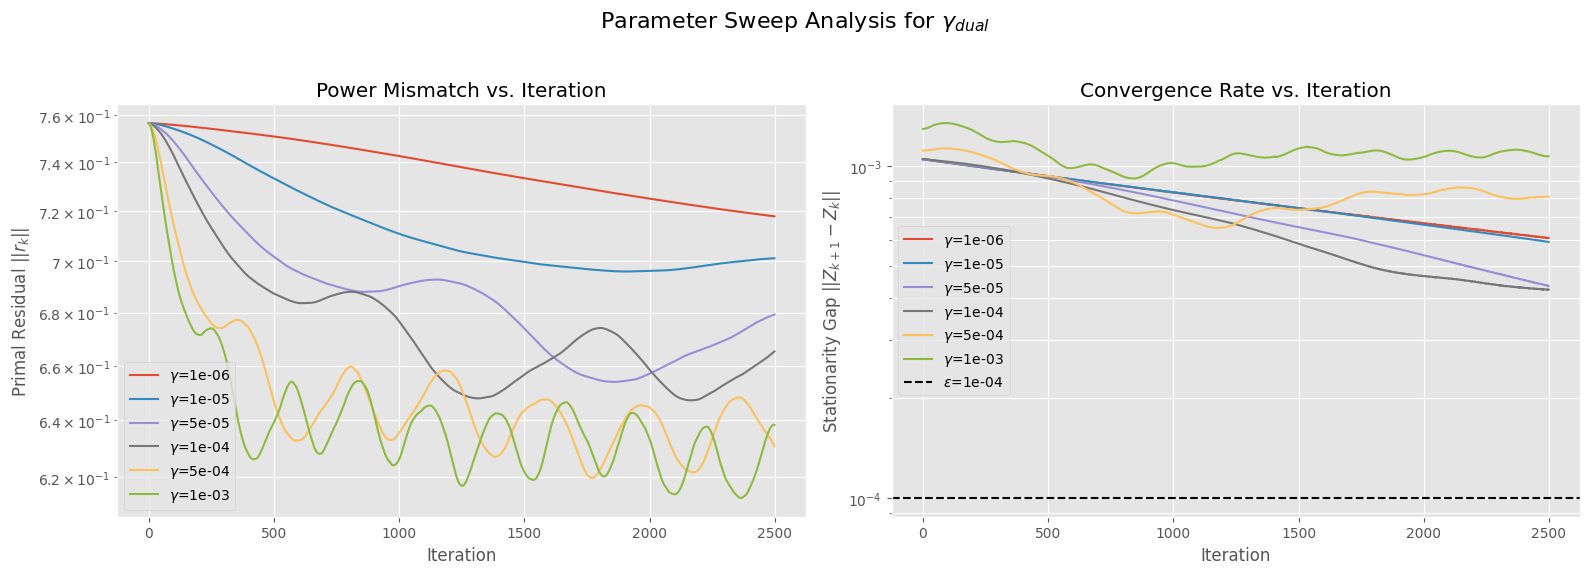

In [25]:
import numpy as np
import pandapower as pp
import pandapower.networks as pn
import matplotlib.pyplot as plt
import networkx as nx
from scipy.sparse import csr_matrix, kron
import copy

# --- Helper Functions (based on the VoltVarController class) ---

def phi_subgrad_z(P, Q, z, S_max):
    """Calculates just the subgradient of the penalty w.r.t. z."""
    g = P**2 + Q**2 - (S_max * z)**2
    if g <= 0.0:
        return 0.0
    return -2.0 * (S_max**2) * z

def prox_phi(v, s_max, z, eta_control, rho_penalty):
    """Proximal operator for tau*rho*phi where tau=eta_control."""
    tau = eta_control * rho_penalty
    r = np.linalg.norm(v)
    R = s_max * z

    # If inside the circle or the circle is non-existent, do nothing
    if r <= R or R < 1e-12:
        return v

    # Scaling factor for the smooth minimization
    a = 1.0 / (1.0 + 2.0 * tau)

    # If scaled vector is still outside, it's the unconstrained minimizer
    if a * r >= R:
        return a * v

    # Otherwise, the minimizer is the projection onto the circle boundary
    return v * (R / r)

# --- 1. Network and Initial State Setup ---

#net = pn.create_cigre_network_lv()
# Add controllable generators

# Run initial power flow to get Jacobian and operating point
#pp.runpp(net, algorithm='nr', calculate_voltage_angles=True, enforce_q_lims=False)

# --- Extract network data and create a temporary controller instance for setup ---
from __main__ import VoltVarController, AlgorithmParameters
temp_params = AlgorithmParameters()
controller = VoltVarController(net, temp_params)

# Unpack all necessary variables from the controller instance
num_buses = controller.num_buses
controllable_buses = controller.controllable_buses
n_ctrl = controller.n_ctrl
ref_bus = controller.ref_bus
H, N, K, L = controller.H, controller.N, controller.K, controller.L
Lg_big = controller.Lg_big
P0, Q0 = controller.P0, controller.Q0
P_load, Q_load = controller.P_load, controller.Q_load
S_max_arr = controller.S_max_arr
V_min_dev, V_max_dev = controller.V_min_dev, controller.V_max_dev

# --- Store initial states for variables ---
initial_P_ctrl = np.copy(controller.P_ctrl)
initial_Q_ctrl = np.copy(controller.Q_ctrl)
initial_Delta_V = np.zeros(num_buses)
initial_Delta_th = np.zeros(num_buses)
initial_z_local = np.zeros(num_buses)
if n_ctrl > 0: initial_z_local[controllable_buses] = 1.0
initial_lambda_P = np.zeros(num_buses)
initial_lambda_Q = np.zeros(num_buses)
initial_s_local = np.zeros(2 * num_buses)

# --- 2. Parameter Sweep Setup ---
print("--- Starting Parameter Sweep for gamma_dual ---")

# Algorithm constants for the sweep
eta_state = 5e-3
eta_control = 5e-3
alpha = 1.0
beta = 0.01
rho_penalty = 0.1
iterations = 2500  # Max iterations per run
eps_iterate = 1e-4 # Convergence tolerance for the stationarity gap

# Parameter sweep values
gamma_dual_values = [1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3]
results_primal_residual = {}
results_convergence = {}

# --- 3. Main Tuning Loop ---

for gamma_dual in gamma_dual_values:
    print(f"\n--- Running with gamma_dual = {gamma_dual:.1e} ---")

    # --- Correctly re-initialize all variables for each run ---
    Delta_V = np.copy(initial_Delta_V)
    Delta_th = np.copy(initial_Delta_th)
    z_local = np.copy(initial_z_local)
    lambda_P = np.copy(initial_lambda_P)
    lambda_Q = np.copy(initial_lambda_Q)
    s_local = np.copy(initial_s_local)
    P_ctrl = np.copy(initial_P_ctrl)
    Q_ctrl = np.copy(initial_Q_ctrl)

    hist_primal_residual = []
    hist_convergence = []

    # Initialize the full state vector Z for convergence tracking
    Z_k = np.concatenate([Delta_V, Delta_th, P_ctrl, Q_ctrl, z_local, lambda_P, lambda_Q, s_local])

    for k in range(iterations):
        # 1. State Update
        gV = 2 * alpha * Delta_V - (N.T @ lambda_P + L.T @ lambda_Q)
        gT = -(H.T @ lambda_P + K.T @ lambda_Q)
        Delta_V = np.clip(Delta_V - eta_state * gV, V_min_dev, V_max_dev)
        Delta_th -= eta_state * gT
        Delta_th[ref_bus] = 0.0

        # 2. Control Update (Prox-Gradient per bus)
        for b in controllable_buses:
            # z-step
            grad_z = (beta + lambda_P[b] * P_ctrl[b] + lambda_Q[b] * Q_ctrl[b]
                      + rho_penalty * phi_subgrad_z(P_ctrl[b], Q_ctrl[b], z_local[b], S_max_arr[b]))
            z_local[b] = np.clip(z_local[b] - eta_control * grad_z, 0.0, 1.0)

            # (P,Q)-step
            grad_P = lambda_P[b] * z_local[b]
            grad_Q = lambda_Q[b] * z_local[b]
            vP = P_ctrl[b] - eta_control * grad_P
            vQ = Q_ctrl[b] - eta_control * grad_Q
            P_ctrl[b], Q_ctrl[b] = prox_phi(np.array([vP, vQ]), S_max_arr[b], z_local[b], eta_control, rho_penalty)

        # 3. Dual Update (lambda)
        P_net_new = -P_load.copy()
        Q_net_new = -Q_load.copy()
        P_net_new[controllable_buses] += P_ctrl[controllable_buses] * z_local[controllable_buses]
        Q_net_new[controllable_buses] += Q_ctrl[controllable_buses] * z_local[controllable_buses]

        primal_residual_P = (P_net_new - P0) - (H @ Delta_th + N @ Delta_V)
        primal_residual_Q = (Q_net_new - Q0) - (K @ Delta_th + L @ Delta_V)

        lambda_P += gamma_dual * primal_residual_P
        lambda_Q += gamma_dual * primal_residual_Q
        # Clip lambdas for stability if they diverge
        # lambda_P = np.clip(lambda_P, -1e4, 1e4)
        # lambda_Q = np.clip(lambda_Q, -1e4, 1e4)

        # 4. Consensus + Innovation Step
        s_local -= eta_state * (Lg_big @ s_local)
        for b in controllable_buses:
            s_local[2 * b]     += eta_state * P_ctrl[b] * z_local[b]
            s_local[2 * b + 1] += eta_state * Q_ctrl[b] * z_local[b]

        # 5. Record History & Check Convergence
        hist_primal_residual.append(np.linalg.norm(np.hstack([primal_residual_P, primal_residual_Q])))

        Z_k_plus_1 = np.concatenate([Delta_V, Delta_th, P_ctrl, Q_ctrl, z_local, lambda_P, lambda_Q, s_local])
        iterate_change = np.linalg.norm(Z_k_plus_1 - Z_k)
        hist_convergence.append(iterate_change)
        Z_k = Z_k_plus_1

        if k > 10 and iterate_change < eps_iterate:
            print(f"Converged at iteration k={k+1}")
            break

    results_primal_residual[gamma_dual] = np.array(hist_primal_residual)
    results_convergence[gamma_dual] = np.array(hist_convergence)

# --- 4. Plot Results for Parameter Sweep ---
plt.style.use("ggplot")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Parameter Sweep Analysis for $\\gamma_{dual}$', fontsize=16)

for g, h in results_primal_residual.items():
    ax1.plot(h, label=f'$\\gamma$={g:.0e}')
ax1.set_yscale('log')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Primal Residual $||r_k||$')
ax1.set_title('Power Mismatch vs. Iteration')
ax1.legend()
ax1.grid(True, which='both')

for g, h in results_convergence.items():
    ax2.plot(h, label=f'$\\gamma$={g:.0e}')
ax2.axhline(eps_iterate, color='k', linestyle='--', label=f'$\\epsilon$={eps_iterate:.0e}')
ax2.set_yscale('log')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Stationarity Gap $||Z_{k+1}-Z_k||$')
ax2.set_title('Convergence Rate vs. Iteration')
ax2.legend()
ax2.grid(True, which='both')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

--- Starting Hyperparameter Tuning ---

[GridSearch] Best Score: 6.8353e-01 | Time: 0.6s
Best Params: {'alpha': 1.0, 'beta': 0.01, 'eta_control': 0.005, 'eta_state': 0.005, 'gamma_dual': 0.0001, 'rho_penalty': 0.1}


[I 2025-07-28 15:03:14,064] A new study created in memory with name: no-name-34218a7a-cd46-46ec-bbec-42fecaea3b76
[I 2025-07-28 15:03:14,129] Trial 0 finished with value: 0.7150346722675541 and parameters: {'eta_state': 0.0007354784480958102, 'eta_control': 0.0026877518824253736, 'gamma_dual': 0.00010444241121493221, 'beta': 0.05134203438539676, 'rho_penalty': 0.03458881753573457, 'alpha': 19.242513718689334}. Best is trial 0 with value: 0.7150346722675541.
[I 2025-07-28 15:03:14,180] Trial 1 finished with value: 0.6998879724709546 and parameters: {'eta_state': 0.0007591895180553486, 'eta_control': 0.0016277609616014966, 'gamma_dual': 0.0003287223281674673, 'beta': 0.003862433805916585, 'rho_penalty': 0.010486600678958596, 'alpha': 13.67945354415082}. Best is trial 1 with value: 0.6998879724709546.
[I 2025-07-28 15:03:14,227] Trial 2 finished with value: 0.7238470703555799 and parameters: {'eta_state': 0.00037752142968289546, 'eta_control': 0.0014924598821662953, 'gamma_dual': 3.238030


[SKOPT] Best Score: 6.5764e-01 | Time: 6.1s
Best Params: {'eta_state': 0.004743189615246043, 'eta_control': 0.0001, 'gamma_dual': 0.001, 'beta': 0.001, 'rho_penalty': 0.2, 'alpha': 1.0}


[I 2025-07-28 15:03:14,311] Trial 3 finished with value: 0.7251768300643212 and parameters: {'eta_state': 0.0007040061126766592, 'eta_control': 0.0002415367279213078, 'gamma_dual': 8.403145253882412e-06, 'beta': 0.04709594628787983, 'rho_penalty': 0.11989704556122031, 'alpha': 4.692882837395571}. Best is trial 1 with value: 0.6998879724709546.
[I 2025-07-28 15:03:14,362] Trial 4 finished with value: 0.7256229538850777 and parameters: {'eta_state': 0.001013529491002984, 'eta_control': 0.0028105788057695056, 'gamma_dual': 4.287324305983252e-06, 'beta': 0.003829945942231013, 'rho_penalty': 0.04753075866485596, 'alpha': 2.428062299661283}. Best is trial 1 with value: 0.6998879724709546.
[I 2025-07-28 15:03:14,426] Trial 5 finished with value: 0.686061037936121 and parameters: {'eta_state': 0.0006638224569406951, 'eta_control': 0.0001804401828483721, 'gamma_dual': 0.0008653809559107601, 'beta': 0.030715458057874217, 'rho_penalty': 0.05950695610945904, 'alpha': 18.618486088742348}. Best is t


[Optuna] Best Score: 6.7953e-01 | Time: 1.0s
Best Params: {'eta_state': 0.003420923181767192, 'eta_control': 0.00010793238707675302, 'gamma_dual': 0.0009630392088775414, 'beta': 0.019061370963080117, 'rho_penalty': 0.019260096582112567, 'alpha': 15.542637363569376}

--- Plotting convergence with best parameters from Grid Search ---


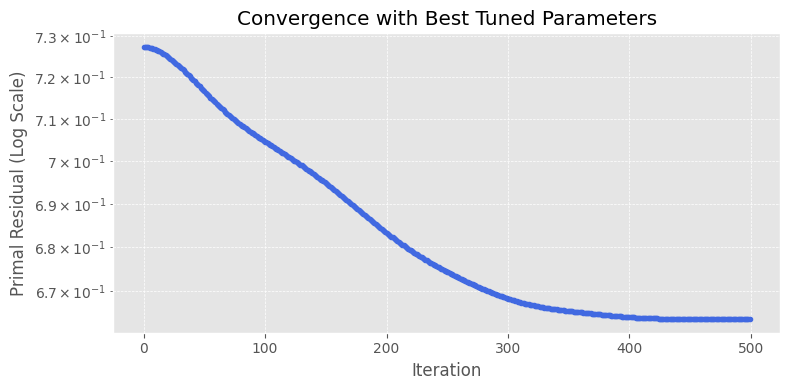

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandapower as pp
import pandapower.networks as pn
import networkx as nx
from sklearn.model_selection import ParameterGrid
from skopt.space import Real
from skopt import gp_minimize
from skopt.utils import use_named_args
import optuna
from scipy.sparse import kron, csr_matrix

# ===================== 1. LOAD NETWORK AND INITIALIZE ==========================
#

# --- Extract all necessary network data and matrices ---
num_buses = len(net.bus)
ref_bus = net.ext_grid.bus.values[0]
controllable_buses = sorted(net.sgen.bus.unique())
P_load = np.zeros(num_buses)
Q_load = np.zeros(num_buses)
if not net.load.empty:
    load_sum = net.load.groupby('bus')[['p_mw', 'q_mvar']].sum()
    P_load[load_sum.index] = load_sum['p_mw']
    Q_load[load_sum.index] = load_sum['q_mvar']
P0 = net.res_bus.p_mw.values
Q0 = net.res_bus.q_mvar.values

vmin, vmax = 0.95, 1.05
V_min_dev = (vmin - 1.0) * np.ones(num_buses)
V_max_dev = (vmax - 1.0) * np.ones(num_buses)

S_max_arr = np.zeros(num_buses)
if controllable_buses:
    sgen_sum = net.sgen.groupby('bus')['sn_mva'].sum()
    S_max_arr[sgen_sum.index] = sgen_sum

G = pp.topology.create_nxgraph(net)
Lg_bus = nx.laplacian_matrix(G, nodelist=sorted(G.nodes())).tocsr()
Lg_big = kron(Lg_bus, csr_matrix(np.eye(2))).tocsr()

J_red = net._ppc['internal']['J'].toarray()
pv_pq_idx = np.hstack([net._ppc['internal']['pv'], net._ppc['internal']['pq']]).astype(int)
m = len(pv_pq_idx)
J_full = np.zeros((2 * num_buses, 2 * num_buses))
J_full[np.ix_(pv_pq_idx, pv_pq_idx)] = J_red[:m, :m]
J_full[np.ix_(pv_pq_idx, num_buses + pv_pq_idx)] = J_red[:m, m:]
J_full[np.ix_(num_buses + pv_pq_idx, pv_pq_idx)] = J_red[m:, :m]
J_full[np.ix_(num_buses + pv_pq_idx, num_buses + pv_pq_idx)] = J_red[m:, m:]
H, N, K, L = J_full[:num_buses, :num_buses], J_full[:num_buses, num_buses:], J_full[num_buses:, :num_buses], J_full[num_buses:, num_buses:]


# ===================== 2. CORRECTED ALGORITHM RUNNER ==========================

def run_consensus_decentralized(params, iterations=200):
    """
    Corrected implementation of the decentralized consensus algorithm.
    """
    # --- Unpack parameters ---
    eta_state = params['eta_state']
    eta_control = params['eta_control']
    gamma_dual = params['gamma_dual']
    beta = params['beta']
    rho_penalty = params['rho_penalty']
    alpha = np.ones(num_buses) * params.get('alpha', 1.0)

    # --- Initialize variables for a fresh run ---
    Delta_V = np.zeros(num_buses); Delta_th = np.zeros(num_buses)
    z_local = np.zeros(num_buses)
    if controllable_buses: z_local[controllable_buses] = 1.0
    lambda_P = np.zeros(num_buses); lambda_Q = np.zeros(num_buses)
    s_local = np.zeros(2 * num_buses)
    P_ctrl = np.zeros(num_buses); Q_ctrl = np.zeros(num_buses)

    best_residual = float('inf')
    hist_primal_residual = []

    # --- Main optimization loop ---
    for k in range(iterations):


        # === Step 1: Primal Update ===
        # A. State update (V, th)
        gV = 2 * alpha * Delta_V - (N.T @ lambda_P + L.T @ lambda_Q)
        gT = -(H.T @ lambda_P + K.T @ lambda_Q)
        Delta_V = np.clip(Delta_V - eta_state * gV, V_min_dev, V_max_dev)
        Delta_th -= eta_state * gT
        Delta_th[ref_bus] = 0.0

        # B. Control update (P_ctrl, Q_ctrl, z) using proximal gradient
        for b in controllable_buses:
            # Subgradient of penalty w.r.t. z
            dphi_dz_val = -2.0 * (S_max_arr[b]**2) * z_local[b] if P_ctrl[b]**2 + Q_ctrl[b]**2 > (S_max_arr[b] * z_local[b])**2 else 0.0

            grad_z = (beta + lambda_P[b] * P_ctrl[b] + lambda_Q[b] * Q_ctrl[b] + rho_penalty * dphi_dz_val)
            z_local[b] = np.clip(z_local[b] - eta_control * grad_z, 0.0, 1.0)

            grad_P = lambda_P[b] * z_local[b]
            grad_Q = lambda_Q[b] * z_local[b]
            vP = P_ctrl[b] - eta_control * grad_P
            vQ = Q_ctrl[b] - eta_control * grad_Q

            # Local Proximal Operator for phi (capability curve)
            tau = eta_control * rho_penalty; v_vec = np.array([vP, vQ])
            r_norm = np.linalg.norm(v_vec); R = S_max_arr[b] * z_local[b]
            if r_norm <= R or R < 1e-9: P_ctrl[b], Q_ctrl[b] = vP, vQ
            else:
                a = 1.0 / (1.0 + 2.0 * tau)
                if a * r_norm >= R: P_ctrl[b], Q_ctrl[b] = a * v_vec
                else: P_ctrl[b], Q_ctrl[b] = v_vec * (R / r_norm)

        # === Step 2: Dual Update ===
        P_net_new = -P_load.copy(); Q_net_new = -Q_load.copy()
        P_net_new[controllable_buses] += P_ctrl[controllable_buses] * z_local[controllable_buses]
        Q_net_new[controllable_buses] += Q_ctrl[controllable_buses] * z_local[controllable_buses]

        primal_residual_P = (P_net_new - P0) - (H @ Delta_th + N @ Delta_V)
        primal_residual_Q = (Q_net_new - Q0) - (K @ Delta_th + L @ Delta_V)

        lambda_P += gamma_dual * primal_residual_P
        lambda_Q += gamma_dual * primal_residual_Q

        # === Step 3: Consensus Update ===
        s_local -= eta_state * (Lg_big @ s_local)  # Consensus/diffusion step
        for b in controllable_buses: # Innovation step
            s_local[2 * b]     += eta_state * P_ctrl[b] * z_local[b]
            s_local[2 * b + 1] += eta_state * Q_ctrl[b] * z_local[b]

        # === Step 4: Record Metrics ===
        res = np.linalg.norm(np.hstack([primal_residual_P, primal_residual_Q]))
        hist_primal_residual.append(res)
        if res < best_residual: best_residual = res

    return best_residual, hist_primal_residual

# ===================== 3. HYPERPARAMETER TUNING SETUPS =======================

# Define the parameter spaces for each library
param_space_grid = {
    'eta_state': [1e-3, 5e-3], 'eta_control': [1e-3, 5e-3],
    'gamma_dual': [1e-5, 5e-5, 1e-4], 'beta': [0.01], 'rho_penalty': [0.1], 'alpha': [1.0],
}

skopt_space = [
    Real(1e-4, 5e-3, "log-uniform", name='eta_state'), Real(1e-4, 5e-3, "log-uniform", name='eta_control'),
    Real(1e-6, 1e-3, "log-uniform", name='gamma_dual'), Real(1e-3, 0.1, "log-uniform", name='beta'),
    Real(1e-2, 0.2, "log-uniform", name='rho_penalty'), Real(1.0, 20.0, "uniform", name='alpha'),
]

# Define objective functions for each tuner
@use_named_args(skopt_space)
def skopt_objective(**params):
    score, _ = run_consensus_decentralized(params)
    return score

def optuna_objective(trial):
    params = {
        'eta_state': trial.suggest_float('eta_state', 1e-4, 5e-3, log=True),
        'eta_control': trial.suggest_float('eta_control', 1e-4, 5e-3, log=True),
        'gamma_dual': trial.suggest_float('gamma_dual', 1e-6, 1e-3, log=True),
        'beta': trial.suggest_float('beta', 1e-3, 0.1, log=True),
        'rho_penalty': trial.suggest_float('rho_penalty', 1e-2, 0.2, log=True),
        'alpha': trial.suggest_float('alpha', 1.0, 20.0),
    }
    score, _ = run_consensus_decentralized(params)
    return score

# ========================= 4. RUN TUNING EXPERIMENTS ==========================
# This section runs the different tuning frameworks.

print("--- Starting Hyperparameter Tuning ---")

# --- Grid Search ---
t0 = time.time()
best_score_gs, best_params_gs = float('inf'), None
for p in ParameterGrid(param_space_grid):
    s, _ = run_consensus_decentralized(p)
    if s < best_score_gs: best_score_gs, best_params_gs = s, p
print(f"\n[GridSearch] Best Score: {best_score_gs:.4e} | Time: {time.time() - t0:.1f}s")
print("Best Params:", best_params_gs)

# --- SKOPT (Bayesian Optimization) ---
t1 = time.time()
res_skopt = gp_minimize(skopt_objective, skopt_space, n_calls=15, n_initial_points=5, random_state=42)
print(f"\n[SKOPT] Best Score: {res_skopt.fun:.4e} | Time: {time.time() - t1:.1f}s")
print("Best Params:", dict(zip([d.name for d in skopt_space], res_skopt.x)))

# --- Optuna ---
t2 = time.time()
study = optuna.create_study(direction="minimize")
study.optimize(optuna_objective, n_trials=15)
print(f"\n[Optuna] Best Score: {study.best_value:.4e} | Time: {time.time() - t2:.1f}s")
print("Best Params:", study.best_params)

# ========================= 5. PLOT BEST RESULT ===============================
print("\n--- Plotting convergence with best parameters from Grid Search ---")
_, hist_residual = run_consensus_decentralized(best_params_gs, iterations=500)

plt.figure(figsize=(8, 4))
plt.plot(hist_residual, '.-', color='royalblue')
plt.yscale('log')
plt.xlabel("Iteration")
plt.ylabel("Primal Residual (Log Scale)")
plt.title("Convergence with Best Tuned Parameters")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()